# Advanced Retriever with BM25, Reranking, and Hierarchical Exploration

### Initial Embedder manager - for fetching from index

In [1]:
# Notebook 1: Setup and Data Loading
import json
import os
import faiss
import numpy as np
from typing import List, Dict, Any
from sentence_transformers import SentenceTransformer
import pickle
from pathlib import Path
import logging
import PyPDF2
import spacy
import json
from typing import List, Dict, Any
from pathlib import Path
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import logging


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class FAISSEmbeddingManager:
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', base_path: str = 'NEW_faiss'):
        """
        Initialize the FAISS Embedding Manager
        """
        self.model_name = model_name
        self.base_path = Path(base_path)
        self.base_path.mkdir(parents=True, exist_ok=True)
        
        logging.info(f"Loading model: {model_name}")
        self.model = SentenceTransformer(model_name)
        self.dimension = self.model.get_sentence_embedding_dimension()
        
        self.index = faiss.IndexFlatL2(self.dimension)
        self.chunk_metadata = {}
        self.current_id = 0
        
        # Add NLP and vectorizer
        self.nlp = spacy.load("en_core_web_sm")
        self.vectorizer = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            min_df=1
        )
    
    def load_chunks(self, json_path: str) -> List[Dict[str, Any]]:
        """
        Load chunks from JSON file with proper UTF-8 encoding
        """
        logging.info(f"Loading chunks from {json_path}")
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            logging.info(f"Successfully loaded {len(data['chunks'])} chunks")
            return data['chunks']
        except UnicodeDecodeError:
            logging.warning("UTF-8 decoding failed, trying with utf-8-sig encoding")
            try:
                with open(json_path, 'r', encoding='utf-8-sig') as f:
                    data = json.load(f)
                logging.info(f"Successfully loaded {len(data['chunks'])} chunks with utf-8-sig encoding")
                return data['chunks']
            except Exception as e:
                logging.error(f"Error loading chunks with utf-8-sig: {str(e)}")
                raise
        except Exception as e:
            logging.error(f"Error loading chunks: {str(e)}")
            raise
    
    def embed_chunk(self, chunk: Dict[str, Any]) -> np.ndarray:
        """
        Create embedding for a single chunk
        """
        text = chunk['content']
        try:
            embedding = self.model.encode([text])[0]
            return embedding
        except Exception as e:
            logging.error(f"Error embedding chunk {chunk['id']}: {str(e)}")
            raise
    
    def add_chunk(self, chunk: Dict[str, Any]):
        """
        Add a single chunk to the FAISS index
        """
        try:
            embedding = self.embed_chunk(chunk)
            self.index.add(embedding.reshape(1, -1))
            
            self.chunk_metadata[self.current_id] = {
                'chunk_id': chunk['id'],
                'content': chunk['content'],
                'topics': chunk.get('topics', []),
                'tokens': chunk.get('tokens', 0),
                'entities': chunk.get('entities', [])
            }
            
            self.current_id += 1
            if self.current_id % 10 == 0:  # Log progress every 10 chunks
                logging.info(f"Processed {self.current_id} chunks")
                
        except Exception as e:
            logging.error(f"Error adding chunk {chunk['id']}: {str(e)}")
            raise
    
    def add_chunks(self, chunks: List[Dict[str, Any]]):
        """Add multiple chunks to the FAISS index"""
        logging.info(f"Adding {len(chunks)} chunks to FAISS index")
        
        # First, fit vectorizer on all chunk contents
        all_contents = [chunk['content'] for chunk in chunks]
        self.vectorizer.fit(all_contents)
        
        # Then add chunks
        for chunk in chunks:
            self.add_chunk(chunk)
        logging.info("Finished adding chunks")
    
    def save(self, index_name: str):
        """
        Save FAISS index and metadata
        """
        index_path = self.base_path / f"{index_name}.index"
        metadata_path = self.base_path / f"{index_name}_metadata.pkl"
        
        logging.info(f"Saving FAISS index to {index_path}")
        faiss.write_index(self.index, str(index_path))
        
        logging.info(f"Saving metadata to {metadata_path}")
        with open(metadata_path, 'wb') as f:
            pickle.dump(self.chunk_metadata, f)
            
        # Also save vectorizer
        vectorizer_path = self.base_path / f"{index_name}_vectorizer.pkl"
        logging.info(f"Saving vectorizer to {vectorizer_path}")
        with open(vectorizer_path, 'wb') as f:
            pickle.dump(self.vectorizer, f)
    
    def load(self, index_name: str):
        """
        Load FAISS index and metadata
        """
        index_path = self.base_path / f"{index_name}.index"
        metadata_path = self.base_path / f"{index_name}_metadata.pkl"
        
        logging.info(f"Loading FAISS index from {index_path}")
        self.index = faiss.read_index(str(index_path))
        
        logging.info(f"Loading metadata from {metadata_path}")
        with open(metadata_path, 'rb') as f:
            self.chunk_metadata = pickle.load(f)
            self.current_id = len(self.chunk_metadata)
            
        # Also load vectorizer
        vectorizer_path = self.base_path / f"{index_name}_vectorizer.pkl"
        logging.info(f"Loading vectorizer from {vectorizer_path}")
        with open(vectorizer_path, 'rb') as f:
            self.vectorizer = pickle.load(f)

    def search(self, query: str, k: int = 5) -> List[Dict[str, Any]]:
        """
        Search for similar chunks
        """
        query_embedding = self.model.encode([query])[0]
        distances, indices = self.index.search(query_embedding.reshape(1, -1), k)
        
        results = []
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                result = self.chunk_metadata[idx].copy()
                result['distance'] = float(distances[0][i])
                results.append(result)
        
        return results

C:\Users\prana\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Custom++ Retrievers

In [4]:
import numpy as np
from typing import List, Dict, Any, Tuple, Set
import logging
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import CrossEncoder
import spacy
import faiss
import math
from collections import Counter, defaultdict
from abc import ABC, abstractmethod
from pathlib import Path
import pickle

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class BaseRetriever(ABC):
    """Base abstract class for all retrievers"""
    
    def __init__(self, embedding_manager=None):
        self.manager = embedding_manager
        self.name = "base"
    
    @abstractmethod
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        """
        Retrieve relevant chunks for a given query
        
        Args:
            query: The search query
            k: Number of results to return
            
        Returns:
            List of chunk results with relevance scores
        """
        pass


class BM25Scorer:
    """BM25 scoring implementation for keyword-based relevance"""
    
    def __init__(self, k1=1.5, b=0.75):
        """
        Initialize BM25 scorer
        
        Args:
            k1: Term frequency saturation parameter
            b: Length normalization parameter
        """
        self.k1 = k1
        self.b = b
        self.doc_freqs = defaultdict(int)  # Document frequencies
        self.doc_lengths = []  # Length of each document
        self.avg_doc_length = 0
        self.total_docs = 0
        self.chunk_keywords = []  # Processed keywords for each chunk
        self.chunk_ids = []  # Original chunk IDs
        self.id_to_idx = {}  # Mapping from chunk_id to index
        
    def extract_keywords(self, chunk: Dict[str, Any]) -> List[str]:
        """
        Extract keywords from a chunk
        
        Args:
            chunk: The chunk to process
            
        Returns:
            List of keywords
        """
        keywords = []
        
        # Add topics if available
        if 'topics' in chunk and chunk['topics']:
            keywords.extend(chunk['topics'])
            
        # Add entity texts if available
        if 'entities' in chunk and chunk['entities']:
            keywords.extend([entity['text'].lower() for entity in chunk['entities']])
            
        # Add important words from content
        if 'content' in chunk and chunk['content']:
            # Simple content-based keywords
            content_words = chunk['content'].lower().split()
            # Filter out short words and common stopwords
            content_words = [w for w in content_words if len(w) > 3]
            keywords.extend(content_words)
            
        return list(set(keywords))  # Remove duplicates
        
    def index_chunks(self, chunks: List[Dict[str, Any]]):
        """
        Index chunks for BM25 scoring
        
        Args:
            chunks: List of chunks to index
        """
        logging.info(f"Indexing {len(chunks)} chunks for BM25 scoring")
        self.total_docs = len(chunks)
        self.chunk_ids = [chunk.get('id', chunk.get('chunk_id', f'unknown_{i}')) for i, chunk in enumerate(chunks)]
        
        # Create mapping from chunk_id to index
        self.id_to_idx = {chunk_id: i for i, chunk_id in enumerate(self.chunk_ids)}
        
        # Process each chunk
        for chunk in chunks:
            # Extract keywords
            keywords = self.extract_keywords(chunk)
            self.chunk_keywords.append(keywords)
            
            # Update document frequencies
            for keyword in set(keywords):  # Use set to count each term once per document
                self.doc_freqs[keyword] += 1
            
            # Update document lengths
            self.doc_lengths.append(len(keywords))
            
        # Calculate average document length
        self.avg_doc_length = sum(self.doc_lengths) / max(1, self.total_docs)
        logging.info(f"BM25 indexing complete. Average document length: {self.avg_doc_length:.2f}")
        
    def score(self, query_keywords: List[str], doc_idx: int) -> float:
        """
        Calculate BM25 score for a document
        
        Args:
            query_keywords: List of keywords from the query
            doc_idx: Index of the document to score
            
        Returns:
            BM25 score
        """
        score = 0
        doc_length = self.doc_lengths[doc_idx]
        doc_keywords = self.chunk_keywords[doc_idx]
        
        # Count query terms in document
        doc_term_counts = Counter(doc_keywords)
        
        for query_term in query_keywords:
            if query_term not in doc_term_counts:
                continue
                
            # Calculate IDF
            df = self.doc_freqs.get(query_term, 0)
            if df == 0:
                continue
            idf = math.log((self.total_docs - df + 0.5) / (df + 0.5) + 1)
            
            # Calculate TF with saturation and length normalization
            tf = doc_term_counts[query_term]
            tf_normalized = ((tf * (self.k1 + 1)) / 
                           (tf + self.k1 * (1 - self.b + self.b * doc_length / self.avg_doc_length)))
            
            score += idf * tf_normalized
            
        return score
    
    def get_scores(self, query: str) -> List[Tuple[str, float]]:
        """
        Get BM25 scores for all documents
        
        Args:
            query: Search query
            
        Returns:
            List of (chunk_id, score) tuples
        """
        # Process query keywords
        query_keywords = query.lower().split()
        
        # Calculate scores for all documents
        scores = []
        for i in range(len(self.chunk_keywords)):
            score = self.score(query_keywords, i)
            scores.append((self.chunk_ids[i], score))
        
        # Normalize scores
        max_score = max([score for _, score in scores]) if scores else 1
        if max_score > 0:
            normalized_scores = [(chunk_id, score/max_score) for chunk_id, score in scores]
        else:
            normalized_scores = scores
            
        return normalized_scores
    
    def get_top_k(self, query: str, k: int = 5) -> List[Tuple[str, float]]:
        """
        Get top-k chunks by BM25 score
        
        Args:
            query: Search query
            k: Number of results to return
            
        Returns:
            List of (chunk_id, score) tuples for top-k results
        """
        scores = self.get_scores(query)
        # Sort by score (descending)
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        return sorted_scores[:k]



In [5]:

class FAISSIndexManager:
    """Manager for FAISS indices"""
    
    def __init__(self, base_path: str = 'NEW_faiss'):
        """
        Initialize FAISS index manager
        
        Args:
            base_path: Path to FAISS index directory
        """
        self.base_path = Path(base_path)
        self.indices = {}
        self.metadata = {}
        
    def load_index(self, index_name: str):
        """
        Load a FAISS index and its metadata
        
        Args:
            index_name: Name of the index to load
        """
        index_path = self.base_path / f"{index_name}.index"
        metadata_path = self.base_path / f"{index_name}_metadata.pkl"
        
        if not index_path.exists() or not metadata_path.exists():
            raise FileNotFoundError(f"Index {index_name} not found at {self.base_path}")
        
        logging.info(f"Loading index {index_name}")
        self.indices[index_name] = faiss.read_index(str(index_path))
        
        with open(metadata_path, 'rb') as f:
            self.metadata[index_name] = pickle.load(f)
            
        logging.info(f"Loaded index {index_name} with {len(self.metadata[index_name])} chunks")
        
    def get_metadata_by_id(self, index_name: str, chunk_id: str) -> Dict[str, Any]:
        """
        Get metadata for a chunk by its ID
        
        Args:
            index_name: Name of the index
            chunk_id: ID of the chunk
            
        Returns:
            Chunk metadata
        """
        # Find metadata by chunk_id
        for idx, metadata in self.metadata[index_name].items():
            if metadata.get('id', metadata.get('chunk_id')) == chunk_id:
                return metadata
        return None
    
    def get_faiss_id_by_chunk_id(self, index_name: str, chunk_id: str) -> int:
        """
        Get FAISS index ID for a chunk
        
        Args:
            index_name: Name of the index
            chunk_id: ID of the chunk
            
        Returns:
            FAISS index ID
        """
        for idx, metadata in self.metadata[index_name].items():
            if metadata.get('id', metadata.get('chunk_id')) == chunk_id:
                return idx
        return -1
    
    def search(self, index_name: str, query_embedding: np.ndarray, k: int = 5) -> List[Tuple[int, float]]:
        """
        Search FAISS index
        
        Args:
            index_name: Name of the index to search
            query_embedding: Query embedding vector
            k: Number of results to return
            
        Returns:
            List of (idx, distance) tuples
        """
        if index_name not in self.indices:
            raise ValueError(f"Index {index_name} not loaded")
            
        distances, indices = self.indices[index_name].search(
            query_embedding.reshape(1, -1), k
        )
        
        results = []
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                results.append((idx, float(distances[0][i])))
                
        return results
    
    def search_by_ids(self, index_name: str, query_embedding: np.ndarray, chunk_ids: List[str], 
                      k: int = 5) -> List[Tuple[str, float]]:
        """
        Search only within specified chunk IDs
        
        Args:
            index_name: Name of the index to search
            query_embedding: Query embedding vector
            chunk_ids: List of chunk IDs to search within
            k: Number of results to return
            
        Returns:
            List of (chunk_id, similarity) tuples
        """
        if index_name not in self.indices:
            raise ValueError(f"Index {index_name} not loaded")
            
        # Get FAISS IDs for chunk IDs
        faiss_ids = []
        for chunk_id in chunk_ids:
            faiss_id = self.get_faiss_id_by_chunk_id(index_name, chunk_id)
            if faiss_id != -1:
                faiss_ids.append(faiss_id)
                
        if not faiss_ids:
            return []
            
        # Get embeddings for these IDs
        embeddings = np.vstack([
            self.indices[index_name].reconstruct(faiss_id) 
            for faiss_id in faiss_ids
        ])
        
        # Compute similarities
        query_norm = np.linalg.norm(query_embedding)
        embedding_norms = np.linalg.norm(embeddings, axis=1)
        similarities = np.dot(embeddings, query_embedding) / (embedding_norms * query_norm)
        
        # Create result tuples
        results = []
        for i, faiss_id in enumerate(faiss_ids):
            chunk_id = self.metadata[index_name][faiss_id].get('id', self.metadata[index_name][faiss_id].get('chunk_id'))
            results.append((chunk_id, float(similarities[i])))
            
        # Sort by similarity (descending)
        results = sorted(results, key=lambda x: x[1], reverse=True)
        return results[:k]

   


In [1]:

class FAISSIndexManager:
    """Manager for FAISS indices"""
    
    def __init__(self, base_path: str = 'NEW_faiss'):
        """
        Initialize FAISS index manager
        
        Args:
            base_path: Path to FAISS index directory
        """
        self.base_path = Path(base_path)
        self.indices = {}
        self.metadata = {}
        
    def load_index(self, index_name: str):
        """
        Load a FAISS index and its metadata
        
        Args:
            index_name: Name of the index to load
        """
        index_path = self.base_path / f"{index_name}.index"
        metadata_path = self.base_path / f"{index_name}_metadata.pkl"
        
        if not index_path.exists() or not metadata_path.exists():
            raise FileNotFoundError(f"Index {index_name} not found at {self.base_path}")
        
        logging.info(f"Loading index {index_name}")
        self.indices[index_name] = faiss.read_index(str(index_path))
        
        with open(metadata_path, 'rb') as f:
            self.metadata[index_name] = pickle.load(f)
            
        logging.info(f"Loaded index {index_name} with {len(self.metadata[index_name])} chunks")
        
    def get_metadata_by_id(self, index_name: str, chunk_id: str) -> Dict[str, Any]:
        """
        Get metadata for a chunk by its ID
        
        Args:
            index_name: Name of the index
            chunk_id: ID of the chunk
            
        Returns:
            Chunk metadata
        """
        # Find metadata by chunk_id
        for idx, metadata in self.metadata[index_name].items():
            if metadata.get('id', metadata.get('chunk_id')) == chunk_id:
                return metadata
        return None
    
    def get_faiss_id_by_chunk_id(self, index_name: str, chunk_id: str) -> int:
        """
        Get FAISS index ID for a chunk
        
        Args:
            index_name: Name of the index
            chunk_id: ID of the chunk
            
        Returns:
            FAISS index ID
        """
        for idx, metadata in self.metadata[index_name].items():
            if metadata.get('id', metadata.get('chunk_id')) == chunk_id:
                return idx
        return -1
    
    def search(self, index_name: str, query_embedding: np.ndarray, k: int = 5) -> List[Tuple[int, float]]:
        """
        Search FAISS index
        
        Args:
            index_name: Name of the index to search
            query_embedding: Query embedding vector
            k: Number of results to return
            
        Returns:
            List of (idx, distance) tuples
        """
        if index_name not in self.indices:
            raise ValueError(f"Index {index_name} not loaded")
            
        distances, indices = self.indices[index_name].search(
            query_embedding.reshape(1, -1), k
        )
        
        results = []
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                results.append((idx, float(distances[0][i])))
                
        return results
    
    def search_by_ids(self, index_name: str, query_embedding: np.ndarray, chunk_ids: List[str], 
                      k: int = 5) -> List[Tuple[str, float]]:
        """
        Search only within specified chunk IDs
        
        Args:
            index_name: Name of the index to search
            query_embedding: Query embedding vector
            chunk_ids: List of chunk IDs to search within
            k: Number of results to return
            
        Returns:
            List of (chunk_id, similarity) tuples
        """
        if index_name not in self.indices:
            raise ValueError(f"Index {index_name} not loaded")
            
        # Get FAISS IDs for chunk IDs
        faiss_ids = []
        for chunk_id in chunk_ids:
            faiss_id = self.get_faiss_id_by_chunk_id(index_name, chunk_id)
            if faiss_id != -1:
                faiss_ids.append(faiss_id)
                
        if not faiss_ids:
            return []
            
        # Get embeddings for these IDs
        embeddings = np.vstack([
            self.indices[index_name].reconstruct(faiss_id) 
            for faiss_id in faiss_ids
        ])
        
        # Compute similarities
        query_norm = np.linalg.norm(query_embedding)
        embedding_norms = np.linalg.norm(embeddings, axis=1)
        similarities = np.dot(embeddings, query_embedding) / (embedding_norms * query_norm)
        
        # Create result tuples
        results = []
        for i, faiss_id in enumerate(faiss_ids):
            chunk_id = self.metadata[index_name][faiss_id].get('id', self.metadata[index_name][faiss_id].get('chunk_id'))
            results.append((chunk_id, float(similarities[i])))
            
        # Sort by similarity (descending)
        results = sorted(results, key=lambda x: x[1], reverse=True)
        return results[:k]

   

class AdvancedHybridRetriever(BaseRetriever):
    """
    Advanced hybrid retriever with BM25, reranking, and hierarchical exploration
    """
    
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', 
                 reranker_model: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2',
                 candidate_pool_size: int = 100,
                 base_path: str = 'NEW_faiss'):
        """
        Initialize the advanced hybrid retriever
        
        Args:
            model_name: Name of the sentence transformer model
            reranker_model: Name of the cross-encoder model for reranking
            candidate_pool_size: Number of candidate chunks to retrieve initially
            base_path: Path to FAISS indices
        """
        super().__init__()
        self.name = "advanced_hybrid"
        self.model_name = model_name
        self.candidate_pool_size = candidate_pool_size
        
        # Set up components
        from sentence_transformers import SentenceTransformer
        self.encoder = SentenceTransformer(model_name)
        self.reranker = CrossEncoder(reranker_model)
        self.nlp = spacy.load("en_core_web_sm")
        
        # Set up FAISS index manager
        self.index_manager = FAISSIndexManager(base_path)
        
        # Set up BM25 scorer
        self.bm25_scorer = BM25Scorer()
        
        # Indices that we'll use
        self.metadata_index = 's3_metadata'  # For initial retrieval
        self.content_index = 's3_content'    # For content-based comparisons
        self.combined_index = 's3_combined'  # For final results
        
        # Tracking variables for performance analysis
        self.hierarchical_improvements = 0
        self.queries_processed = 0
        
    def initialize(self):
        """Load indices and prepare BM25 scorer"""
        # Load indices
        self.index_manager.load_index(self.metadata_index)
        self.index_manager.load_index(self.content_index)
        self.index_manager.load_index(self.combined_index)
        
        # Initialize BM25 scorer with chunks from combined index
        chunks = [
            metadata for metadata in self.index_manager.metadata[self.combined_index].values()
        ]
        self.bm25_scorer.index_chunks(chunks)
        
        logging.info("AdvancedHybridRetriever initialized successfully")
        
    def get_hierarchical_chunks(self, chunk_ids: List[str]) -> Set[str]:
        """
        Get parent and child chunks for a set of chunk IDs
        
        Args:
            chunk_ids: List of chunk IDs
            
        Returns:
            Set of related chunk IDs (parents and children)
        """
        related_chunks = set()
        
        for chunk_id in chunk_ids:
            # Get chunk metadata
            chunk = self.index_manager.get_metadata_by_id(self.combined_index, chunk_id)
            if not chunk:
                continue
                
            # Add parent chunks
            if 'parent' in chunk and chunk['parent']:
                if isinstance(chunk['parent'], list):
                    related_chunks.update(chunk['parent'])
                else:
                    related_chunks.add(chunk['parent'])
                    
            # Add child chunks
            if 'children' in chunk and chunk['children']:
                if isinstance(chunk['children'], list):
                    related_chunks.update(chunk['children'])
                else:
                    related_chunks.add(chunk['children'])
                    
        # Remove any IDs that were in the original set
        related_chunks = related_chunks - set(chunk_ids)
        return related_chunks
        
    def retrieve(self, query: str, k: int = 3, use_hierarchical: bool = True) -> List[Dict[str, Any]]:
        """
        Retrieve relevant chunks using the advanced hybrid approach
        
        Args:
            query: The search query
            k: Number of results to return
            use_hierarchical: Whether to use hierarchical exploration
            
        Returns:
            List of chunk results with relevance scores
        """
        start_time = time.time()
        self.queries_processed += 1
        
        # Step 1: Get query embedding
        query_embedding = self.encoder.encode(query)
        
        # Step 2: Use BM25 to get initial candidates
        logging.info(f"Getting initial candidates using BM25 (pool size: {self.candidate_pool_size})")
        bm25_results = self.bm25_scorer.get_top_k(query, k=self.candidate_pool_size)
        candidate_ids = [chunk_id for chunk_id, _ in bm25_results]
        
        # Step 3: Rerank candidates using dense embeddings
        logging.info(f"Reranking {len(candidate_ids)} candidates using dense embeddings")
        vector_results = self.index_manager.search_by_ids(
            self.combined_index, query_embedding, candidate_ids, k=self.candidate_pool_size
        )
        
        # Step 4: Get top-k chunks for further reranking
        top_k_candidates = vector_results[:k*2]  # Get 2*k for reranking
        top_k_ids = [chunk_id for chunk_id, _ in top_k_candidates]
        
        # Step 5: Prepare texts for reranker
        texts_to_rerank = []
        for chunk_id in top_k_ids:
            chunk = self.index_manager.get_metadata_by_id(self.combined_index, chunk_id)
            if chunk and 'content' in chunk:
                texts_to_rerank.append(chunk['content'])
            else:
                texts_to_rerank.append("")  # Empty string as placeholder
                
        # Step 6: Rerank using cross-encoder
        logging.info(f"Reranking top {len(texts_to_rerank)} candidates using cross-encoder")
        rerank_inputs = [[query, text] for text in texts_to_rerank]
        rerank_scores = self.reranker.predict(rerank_inputs)
        
        # Combine chunk IDs with rerank scores
        reranked_results = list(zip(top_k_ids, rerank_scores))
        reranked_results.sort(key=lambda x: x[1], reverse=True)
        
        # Step 7: Get top-k results
        top_k_results = reranked_results[:k]
        final_chunk_ids = [chunk_id for chunk_id, _ in top_k_results]
        
        # Step 8: Hierarchical exploration (optional)
        hierarchical_helped = False
        if use_hierarchical:
            logging.info("Performing hierarchical exploration")
            # Get hierarchically related chunks
            related_ids = self.get_hierarchical_chunks(final_chunk_ids)
            
            if related_ids:
                logging.info(f"Found {len(related_ids)} related chunks")
                # Get similarity scores for related chunks
                related_results = self.index_manager.search_by_ids(
                    self.combined_index, query_embedding, list(related_ids), k=len(related_ids)
                )
                
                # Only keep related chunks with scores above threshold
                min_score = min([score for _, score in top_k_results])
                good_related = [(chunk_id, score) for chunk_id, score in related_results if score > min_score]
                
                if good_related:
                    logging.info(f"Found {len(good_related)} related chunks with scores above threshold")
                    # Add to final results
                    combined_results = top_k_results + good_related
                    combined_results.sort(key=lambda x: x[1], reverse=True)
                    
                    # Check if hierarchical exploration helped
                    if combined_results[0][0] not in final_chunk_ids:
                        hierarchical_helped = True
                        self.hierarchical_improvements += 1
                        
                    # Update final chunk IDs
                    final_chunk_ids = [chunk_id for chunk_id, _ in combined_results[:k]]
        
        # Step 9: Prepare final results
        final_results = []
        for chunk_id in final_chunk_ids:
            chunk = self.index_manager.get_metadata_by_id(self.combined_index, chunk_id)
            if chunk:
                result = chunk.copy()
                result['hierarchical_boost'] = hierarchical_helped
                final_results.append(result)
                
        elapsed = time.time() - start_time
        logging.info(f"Retrieval completed in {elapsed:.2f} seconds")
        if hierarchical_helped:
            logging.info("Hierarchical exploration improved results!")
            
        return final_results
    
    def get_hierarchical_stats(self) -> Dict[str, Any]:
        """
        Get statistics on hierarchical exploration effectiveness
        
        Returns:
            Dictionary with statistics
        """
        if self.queries_processed == 0:
            return {
                "queries_processed": 0,
                "hierarchical_improvements": 0,
                "improvement_rate": 0
            }
            
        return {
            "queries_processed": self.queries_processed,
            "hierarchical_improvements": self.hierarchical_improvements,
            "improvement_rate": self.hierarchical_improvements / self.queries_processed
        }
     

NameError: name 'Dict' is not defined

In [7]:
# Initialize the retriever
retriever = AdvancedHybridRetriever(
    model_name='all-MiniLM-L6-v2',
    reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2',
    candidate_pool_size=100,
    base_path='NEW_faiss'
)

# Load indices and prepare BM25
retriever.initialize()



2025-02-25 19:17:56,205 - INFO - Use pytorch device_name: cpu
2025-02-25 19:17:56,205 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
C:\Users\prana\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

C:\Users\prana\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\prana\.cache\huggingface\hub\models--cross-encoder--ms-marco-MiniLM-L-6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

2025-02-25 19:18:01,704 - INFO - Use pytorch device: cpu
2025-02-25 19:18:02,287 - INFO - Loading index s3_metadata
2025-02-25 19:18:02,337 - INFO - Loaded index s3_metadata with 6214 chunks
2025-02-25 19:18:02,338 - INFO - Loading index s3_content
2025-02-25 19:18:02,396 - INFO - Loaded index s3_content with 6214 chunks
2025-02-25 19:18:02,398 - INFO - Loading index s3_combined
2025-02-25 19:18:02,471 - INFO - Loaded index s3_combined with 6214 chunks
2025-02-25 19:18:02,472 - INFO - Indexing 6214 chunks for BM25 scoring
2025-02-25 19:18:02,764 - INFO - BM25 indexing complete. Average document length: 82.43
2025-02-25 19:18:02,765 - INFO - AdvancedHybridRetriever initialized successfully


In [8]:
# Make a query
results = retriever.retrieve(
    "What are the prerequisites for locking a vault in S3 Glacier, and how does this feature enforce compliance?", 
    k=3, 
    use_hierarchical=True
)

# Check if hierarchical exploration helped
stats = retriever.get_hierarchical_stats()
print(f"Hierarchical improvement rate: {stats['improvement_rate']:.2%}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:19:19,593 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 19:19:19,720 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 19:19:19,734 - INFO - Reranking top 6 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:19:20,511 - INFO - Performing hierarchical exploration
2025-02-25 19:19:20,512 - INFO - Found 18 related chunks
2025-02-25 19:19:20,516 - INFO - Found 18 related chunks with scores above threshold
2025-02-25 19:19:20,517 - INFO - Retrieval completed in 4.71 seconds
2025-02-25 19:19:20,518 - INFO - Hierarchical exploration improved results!


Hierarchical improvement rate: 100.00%


In [9]:
results

[{'id': 'chunk_1843',
  'content': 'Amazon Simple Storage Service User Guide\nthen transitions objects to S3 Glacier Deep Archive after 20 days. In this case the S3 Glacier Deep \nArchive transition must occur after at least 94 days.\nYou can specify two rules to accomplish this, but you pay the minimum duration storage charges. \nFor more information about cost considerations, see Amazon S3 pricing.\nFor more information about creating a S3 Lifecycle, see Setting an S3 Lifecycle conﬁguration on a \nbucket.\nTransitioning to the S3 Glacier Flexible Retrieval and S3 Glacier Deep Archive \nstorage classes (object archival)\nBy using an S3 Lifecycle conﬁguration, you can transition objects to the S3 Glacier Flexible \nRetrieval or S3 Glacier Deep Archive storage classes for archiving.\nBefore you archive objects, review the following sections for relevant considerations.\nGeneral considerations\nThe following are the general considerations for you to consider before you archive objects:\n

# 3 Custom retrievers 

## With BM25 + Reranking + Hierarchical adv

In [20]:
import numpy as np
from typing import List, Dict, Any, Tuple, Set
import logging
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import CrossEncoder
import spacy
import faiss
import math
from collections import Counter, defaultdict
from abc import ABC, abstractmethod
from pathlib import Path
import pickle

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class BaseRetriever(ABC):
    """Base abstract class for all retrievers"""
    
    def __init__(self, embedding_manager=None):
        self.manager = embedding_manager
        self.name = "base"
    
    @abstractmethod
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        """
        Retrieve relevant chunks for a given query
        
        Args:
            query: The search query
            k: Number of results to return
            
        Returns:
            List of chunk results with relevance scores
        """
        pass


class BM25Scorer:
    """BM25 scoring implementation for keyword-based relevance"""
    
    def __init__(self, k1=1.5, b=0.75):
        """
        Initialize BM25 scorer
        
        Args:
            k1: Term frequency saturation parameter
            b: Length normalization parameter
        """
        self.k1 = k1
        self.b = b
        self.doc_freqs = defaultdict(int)  # Document frequencies
        self.doc_lengths = []  # Length of each document
        self.avg_doc_length = 0
        self.total_docs = 0
        self.chunk_keywords = []  # Processed keywords for each chunk
        self.chunk_ids = []  # Original chunk IDs
        self.id_to_idx = {}  # Mapping from chunk_id to index
        
    def extract_keywords(self, chunk: Dict[str, Any]) -> List[str]:
        """
        Extract keywords from a chunk
        
        Args:
            chunk: The chunk to process
            
        Returns:
            List of keywords
        """
        keywords = []
        
        # Add topics if available
        if 'topics' in chunk and chunk['topics']:
            keywords.extend(chunk['topics'])
            
        # Add entity texts if available
        if 'entities' in chunk and chunk['entities']:
            keywords.extend([entity['text'].lower() for entity in chunk['entities']])
            
        # Add important words from content
        if 'content' in chunk and chunk['content']:
            # Simple content-based keywords
            content_words = chunk['content'].lower().split()
            # Filter out short words and common stopwords
            content_words = [w for w in content_words if len(w) > 3]
            keywords.extend(content_words)
            
        return list(set(keywords))  # Remove duplicates
        
    def index_chunks(self, chunks: List[Dict[str, Any]]):
        """
        Index chunks for BM25 scoring
        
        Args:
            chunks: List of chunks to index
        """
        logging.info(f"Indexing {len(chunks)} chunks for BM25 scoring")
        self.total_docs = len(chunks)
        self.chunk_ids = [chunk.get('id', chunk.get('chunk_id', f'unknown_{i}')) for i, chunk in enumerate(chunks)]
        
        # Create mapping from chunk_id to index
        self.id_to_idx = {chunk_id: i for i, chunk_id in enumerate(self.chunk_ids)}
        
        # Process each chunk
        for chunk in chunks:
            # Extract keywords
            keywords = self.extract_keywords(chunk)
            self.chunk_keywords.append(keywords)
            
            # Update document frequencies
            for keyword in set(keywords):  # Use set to count each term once per document
                self.doc_freqs[keyword] += 1
            
            # Update document lengths
            self.doc_lengths.append(len(keywords))
            
        # Calculate average document length
        self.avg_doc_length = sum(self.doc_lengths) / max(1, self.total_docs)
        logging.info(f"BM25 indexing complete. Average document length: {self.avg_doc_length:.2f}")
        
    def score(self, query_keywords: List[str], doc_idx: int) -> float:
        """
        Calculate BM25 score for a document
        
        Args:
            query_keywords: List of keywords from the query
            doc_idx: Index of the document to score
            
        Returns:
            BM25 score
        """
        score = 0
        doc_length = self.doc_lengths[doc_idx]
        doc_keywords = self.chunk_keywords[doc_idx]
        
        # Count query terms in document
        doc_term_counts = Counter(doc_keywords)
        
        for query_term in query_keywords:
            if query_term not in doc_term_counts:
                continue
                
            # Calculate IDF
            df = self.doc_freqs.get(query_term, 0)
            if df == 0:
                continue
            idf = math.log((self.total_docs - df + 0.5) / (df + 0.5) + 1)
            
            # Calculate TF with saturation and length normalization
            tf = doc_term_counts[query_term]
            tf_normalized = ((tf * (self.k1 + 1)) / 
                           (tf + self.k1 * (1 - self.b + self.b * doc_length / self.avg_doc_length)))
            
            score += idf * tf_normalized
            
        return score
    
    def get_scores(self, query: str) -> List[Tuple[str, float]]:
        """
        Get BM25 scores for all documents
        
        Args:
            query: Search query
            
        Returns:
            List of (chunk_id, score) tuples
        """
        # Process query keywords
        query_keywords = query.lower().split()
        
        # Calculate scores for all documents
        scores = []
        for i in range(len(self.chunk_keywords)):
            score = self.score(query_keywords, i)
            scores.append((self.chunk_ids[i], score))
        
        # Normalize scores
        max_score = max([score for _, score in scores]) if scores else 1
        if max_score > 0:
            normalized_scores = [(chunk_id, score/max_score) for chunk_id, score in scores]
        else:
            normalized_scores = scores
            
        return normalized_scores
    
    def get_top_k(self, query: str, k: int = 5) -> List[Tuple[str, float]]:
        """
        Get top-k chunks by BM25 score
        
        Args:
            query: Search query
            k: Number of results to return
            
        Returns:
            List of (chunk_id, score) tuples for top-k results
        """
        scores = self.get_scores(query)
        # Sort by score (descending)
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        return sorted_scores[:k]


class FAISSIndexManager:
    """Manager for FAISS indices"""
    
    def __init__(self, base_path: str = 'NEW_faiss'):
        """
        Initialize FAISS index manager
        
        Args:
            base_path: Path to FAISS index directory
        """
        self.base_path = Path(base_path)
        self.indices = {}
        self.metadata = {}
        
    def load_index(self, index_name: str):
        """
        Load a FAISS index and its metadata
        
        Args:
            index_name: Name of the index to load
        """
        index_path = self.base_path / f"{index_name}.index"
        metadata_path = self.base_path / f"{index_name}_metadata.pkl"
        
        if not index_path.exists() or not metadata_path.exists():
            raise FileNotFoundError(f"Index {index_name} not found at {self.base_path}")
        
        logging.info(f"Loading index {index_name}")
        self.indices[index_name] = faiss.read_index(str(index_path))
        
        with open(metadata_path, 'rb') as f:
            self.metadata[index_name] = pickle.load(f)
            
        logging.info(f"Loaded index {index_name} with {len(self.metadata[index_name])} chunks")
        
    def get_metadata_by_id(self, index_name: str, chunk_id: str) -> Dict[str, Any]:
        """
        Get metadata for a chunk by its ID
        
        Args:
            index_name: Name of the index
            chunk_id: ID of the chunk
            
        Returns:
            Chunk metadata
        """
        # Find metadata by chunk_id
        for idx, metadata in self.metadata[index_name].items():
            if metadata.get('id', metadata.get('chunk_id')) == chunk_id:
                return metadata
        return None
    
    def get_faiss_id_by_chunk_id(self, index_name: str, chunk_id: str) -> int:
        """
        Get FAISS index ID for a chunk
        
        Args:
            index_name: Name of the index
            chunk_id: ID of the chunk
            
        Returns:
            FAISS index ID
        """
        for idx, metadata in self.metadata[index_name].items():
            if metadata.get('id', metadata.get('chunk_id')) == chunk_id:
                return idx
        return -1
    
    def search(self, index_name: str, query_embedding: np.ndarray, k: int = 5) -> List[Tuple[int, float]]:
        """
        Search FAISS index
        
        Args:
            index_name: Name of the index to search
            query_embedding: Query embedding vector
            k: Number of results to return
            
        Returns:
            List of (idx, distance) tuples
        """
        if index_name not in self.indices:
            raise ValueError(f"Index {index_name} not loaded")
            
        distances, indices = self.indices[index_name].search(
            query_embedding.reshape(1, -1), k
        )
        
        results = []
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                results.append((idx, float(distances[0][i])))
                
        return results
    
    def search_by_ids(self, index_name: str, query_embedding: np.ndarray, chunk_ids: List[str], 
                      k: int = 5) -> List[Tuple[str, float]]:
        """
        Search only within specified chunk IDs
        
        Args:
            index_name: Name of the index to search
            query_embedding: Query embedding vector
            chunk_ids: List of chunk IDs to search within
            k: Number of results to return
            
        Returns:
            List of (chunk_id, similarity) tuples
        """
        if index_name not in self.indices:
            raise ValueError(f"Index {index_name} not loaded")
            
        # Get FAISS IDs for chunk IDs
        faiss_ids = []
        for chunk_id in chunk_ids:
            faiss_id = self.get_faiss_id_by_chunk_id(index_name, chunk_id)
            if faiss_id != -1:
                faiss_ids.append(faiss_id)
                
        if not faiss_ids:
            return []
            
        # Get embeddings for these IDs
        embeddings = np.vstack([
            self.indices[index_name].reconstruct(faiss_id) 
            for faiss_id in faiss_ids
        ])
        
        # Compute similarities
        query_norm = np.linalg.norm(query_embedding)
        embedding_norms = np.linalg.norm(embeddings, axis=1)
        similarities = np.dot(embeddings, query_embedding) / (embedding_norms * query_norm)
        
        # Create result tuples
        results = []
        for i, faiss_id in enumerate(faiss_ids):
            chunk_id = self.metadata[index_name][faiss_id].get('id', self.metadata[index_name][faiss_id].get('chunk_id'))
            results.append((chunk_id, float(similarities[i])))
            
        # Sort by similarity (descending)
        results = sorted(results, key=lambda x: x[1], reverse=True)
        return results[:k]


class AdvancedRetriever(BaseRetriever):
    """
    Advanced retriever with BM25, reranking, and hierarchical exploration
    """
    
    def __init__(self, 
                 model_name: str = 'all-MiniLM-L6-v2', 
                 reranker_model: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2',
                 candidate_pool_size: int = 100,
                 base_path: str = 'NEW_faiss',
                 retriever_type: str = 'combined'):
        """
        Initialize the advanced retriever
        
        Args:
            model_name: Name of the sentence transformer model
            reranker_model: Name of the cross-encoder model for reranking
            candidate_pool_size: Number of candidate chunks to retrieve initially
            base_path: Path to FAISS indices
            retriever_type: Type of retriever ('content', 'combined', or 'hybrid')
        """
        super().__init__()
        self.retriever_type = retriever_type
        self.name = f"advanced_{retriever_type}"
        self.model_name = model_name
        self.candidate_pool_size = candidate_pool_size
        
        # Set up components
        from sentence_transformers import SentenceTransformer
        self.encoder = SentenceTransformer(model_name)
        self.reranker = CrossEncoder(reranker_model)
        self.nlp = spacy.load("en_core_web_sm")
        
        # Set up FAISS index manager
        self.index_manager = FAISSIndexManager(base_path)
        
        # Set up BM25 scorer
        self.bm25_scorer = BM25Scorer()
        
        # Indices that we'll use
        self.metadata_index = 's3_metadata'  # For initial metadata exploration
        self.content_index = 's3_content'    # For content-based retrieval
        self.combined_index = 's3_combined'  # For combined retrieval
        
        # Set primary index based on retriever type
        if retriever_type == 'content':
            self.primary_index = self.content_index
        elif retriever_type == 'combined':
            self.primary_index = self.combined_index
        elif retriever_type == 'hybrid':
            # Hybrid will use metadata for initial retrieval, then rerank with combined
            self.primary_index = self.combined_index
        else:
            raise ValueError(f"Unknown retriever type: {retriever_type}")
        
        # Tracking variables for performance analysis
        self.hierarchical_improvements = 0
        self.queries_processed = 0
        
    # Fix for the AdvancedRetriever class
    def initialize(self):
        """Load indices and prepare BM25 scorer"""
        # Load only the indices you need
        needed_indices = set([self.primary_index, self.metadata_index])
        for index_name in needed_indices:
            self.index_manager.load_index(index_name)

        # Debug logging
        logging.info(f"Loaded primary index: {self.primary_index}")
        logging.info(f"Primary index memory address: {id(self.index_manager.indices[self.primary_index])}")

        # Check metadata differences
        sample_metadata = list(self.index_manager.metadata[self.primary_index].values())[0]
        logging.info(f"Sample metadata keys: {sample_metadata.keys()}")

        # Initialize BM25 scorer with chunks from primary index
        chunks = [
            metadata for metadata in self.index_manager.metadata[self.primary_index].values()
        ]
        self.bm25_scorer.index_chunks(chunks)

        logging.info(f"{self.retriever_type} retriever initialized successfully with {len(chunks)} chunks")
        
    def get_hierarchical_chunks(self, chunk_ids: List[str]) -> Set[str]:
        """
        Get parent and child chunks for a set of chunk IDs
        
        Args:
            chunk_ids: List of chunk IDs
            
        Returns:
            Set of related chunk IDs (parents and children)
        """
        related_chunks = set()
        
        for chunk_id in chunk_ids:
            # Get chunk metadata
            chunk = self.index_manager.get_metadata_by_id(self.combined_index, chunk_id)
            if not chunk:
                continue
                
            # Add parent chunks
            if 'parent' in chunk and chunk['parent']:
                if isinstance(chunk['parent'], list):
                    related_chunks.update(chunk['parent'])
                else:
                    related_chunks.add(chunk['parent'])
                    
            # Add child chunks
            if 'children' in chunk and chunk['children']:
                if isinstance(chunk['children'], list):
                    related_chunks.update(chunk['children'])
                else:
                    related_chunks.add(chunk['children'])
                    
        # Remove any IDs that were in the original set
        related_chunks = related_chunks - set(chunk_ids)
        return related_chunks
        
    def retrieve(self, query: str, k: int = 3, use_hierarchical: bool = True) -> List[Dict[str, Any]]:
        """
        Retrieve relevant chunks using the advanced approach
        
        Args:
            query: The search query
            k: Number of results to return
            use_hierarchical: Whether to use hierarchical exploration
            
        Returns:
            List of chunk results with relevance scores
        """
        start_time = time.time()
        self.queries_processed += 1
        
        # Step 1: Get query embedding
        query_embedding = self.encoder.encode(query)
        
        # Step 2: Initial retrieval based on retriever type
        if self.retriever_type == 'hybrid':
            # Hybrid approach: First get BM25 candidates, then use vector search
            logging.info(f"Getting initial candidates using BM25 (pool size: {self.candidate_pool_size})")
            bm25_results = self.bm25_scorer.get_top_k(query, k=self.candidate_pool_size)
            bm25_scores = {chunk_id: score for chunk_id, score in bm25_results}
            candidate_ids = [chunk_id for chunk_id, _ in bm25_results]
            
            # Rerank candidates using dense embeddings
            logging.info(f"Reranking {len(candidate_ids)} candidates using dense embeddings")
            vector_results = self.index_manager.search_by_ids(
                self.primary_index, query_embedding, candidate_ids, k=self.candidate_pool_size
            )
            
            # Keep track of both scores
            initial_scores = {}
            for chunk_id, score in vector_results:
                initial_scores[chunk_id] = {
                    'vector': score,
                    'bm25': bm25_scores.get(chunk_id, 0.0)
                }
            
            # Get top candidates for further reranking
            top_k_candidates = vector_results[:k*2]  # Get 2*k for reranking
        else:
            # Content or Combined: Use the primary index directly
            logging.info(f"Using {self.retriever_type} index for initial retrieval")
            
            # First get BM25 scores for all chunks
            bm25_results = self.bm25_scorer.get_top_k(query, k=self.candidate_pool_size)
            bm25_scores = {chunk_id: score for chunk_id, score in bm25_results}
            
            # Then get vector search results
            distances, indices = self.index_manager.indices[self.primary_index].search(
                query_embedding.reshape(1, -1), self.candidate_pool_size
            )
            
            # Convert to chunk IDs and scores
            vector_results = []
            initial_scores = {}
            for i, idx in enumerate(indices[0]):
                if idx != -1:
                    chunk_id = self.index_manager.metadata[self.primary_index][idx].get('id', 
                                 self.index_manager.metadata[self.primary_index][idx].get('chunk_id'))
                    similarity = 1 - (distances[0][i] / 2)  # Convert L2 distance to similarity
                    vector_results.append((chunk_id, similarity))
                    
                    # Store both scores
                    initial_scores[chunk_id] = {
                        'vector': similarity,
                        'bm25': bm25_scores.get(chunk_id, 0.0)
                    }
            
            # Get top candidates for reranking
            top_k_candidates = vector_results[:k*2]
            
        # Get chunk IDs for reranking
        top_k_ids = [chunk_id for chunk_id, _ in top_k_candidates]
        
        # Step 3: Prepare texts for reranker
        texts_to_rerank = []
        for chunk_id in top_k_ids:
            chunk = self.index_manager.get_metadata_by_id(self.primary_index, chunk_id)
            if chunk and 'content' in chunk:
                texts_to_rerank.append(chunk['content'])
            else:
                texts_to_rerank.append("")  # Empty string as placeholder
                
        # Step 4: Rerank using cross-encoder
        logging.info(f"Reranking top {len(texts_to_rerank)} candidates using cross-encoder")
        rerank_inputs = [[query, text] for text in texts_to_rerank]
        rerank_scores = self.reranker.predict(rerank_inputs)
        
        # Combine chunk IDs with rerank scores and update scores dictionary
        reranked_results = []
        for i, (chunk_id, score) in enumerate(zip(top_k_ids, rerank_scores)):
            reranked_results.append((chunk_id, score))
            if chunk_id in initial_scores:
                initial_scores[chunk_id]['reranker'] = score
        
        # Sort by reranker score
        reranked_results.sort(key=lambda x: x[1], reverse=True)
        
        # Step 5: Get top-k results
        top_k_results = reranked_results[:k]
        final_chunk_ids = [chunk_id for chunk_id, _ in top_k_results]
        
        # Step 6: Hierarchical exploration (optional)
        hierarchical_helped = False
        hierarchical_scores = {}
        
        if use_hierarchical:
            logging.info("Performing hierarchical exploration")
            # Get hierarchically related chunks
            related_ids = self.get_hierarchical_chunks(final_chunk_ids)
            
            if related_ids:
                logging.info(f"Found {len(related_ids)} related chunks")
                # Get similarity scores for related chunks
                related_results = self.index_manager.search_by_ids(
                    self.primary_index, query_embedding, list(related_ids), k=len(related_ids)
                )
                
                # Get reranker scores for related chunks
                related_texts = []
                related_chunk_ids = [chunk_id for chunk_id, _ in related_results]
                for chunk_id in related_chunk_ids:
                    chunk = self.index_manager.get_metadata_by_id(self.primary_index, chunk_id)
                    if chunk and 'content' in chunk:
                        related_texts.append(chunk['content'])
                    else:
                        related_texts.append("")
                
                if related_texts:
                    # Only run reranker if we have texts
                    related_inputs = [[query, text] for text in related_texts]
                    related_rerank_scores = self.reranker.predict(related_inputs)
                    
                    # Add scores to dictionary
                    for i, (chunk_id, score) in enumerate(zip(related_chunk_ids, related_rerank_scores)):
                        hierarchical_scores[chunk_id] = {
                            'reranker': score,
                            'relationship': 'hierarchical'
                        }
                    
                    # Only keep related chunks with scores above threshold
                    min_score = min([score for _, score in top_k_results])
                    good_related = [(chunk_id, score) for i, (chunk_id, _) in enumerate(related_results) 
                                   if related_rerank_scores[i] > min_score]
                    
                    if good_related:
                        logging.info(f"Found {len(good_related)} related chunks with scores above threshold")
                        # Add to final results
                        combined_results = top_k_results + good_related
                        combined_results.sort(key=lambda x: x[1], reverse=True)
                        
                        # Check if hierarchical exploration helped
                        if combined_results[0][0] not in final_chunk_ids:
                            hierarchical_helped = True
                            self.hierarchical_improvements += 1
                            logging.info("Hierarchical exploration improved results!")
                            
                        # Update final chunk IDs (keeping within k limit)
                        final_chunk_ids = [chunk_id for chunk_id, _ in combined_results[:k]]
        
        # Step 7: Prepare final results with all scores
        final_results = []
        
        for i, chunk_id in enumerate(final_chunk_ids):
            chunk = self.index_manager.get_metadata_by_id(self.primary_index, chunk_id)
            if chunk:
                result = chunk.copy()
                
                # Add scoring information
                result['scores'] = {
                    'rank': i + 1
                }
                
                # Add initial scores if available
                if chunk_id in initial_scores:
                    result['scores'].update(initial_scores[chunk_id])
                
                # Add hierarchical information
                if chunk_id in hierarchical_scores:
                    result['scores'].update(hierarchical_scores[chunk_id])
                    result['hierarchical_boost'] = True
                else:
                    result['hierarchical_boost'] = False
                
                # Add overall hierarchical helped flag
                result['hierarchical_improved_results'] = hierarchical_helped
                
                final_results.append(result)
                
        elapsed = time.time() - start_time
        logging.info(f"Retrieval completed in {elapsed:.2f} seconds")
            
        return final_results
    
    def get_hierarchical_stats(self) -> Dict[str, Any]:
        """
        Get statistics on hierarchical exploration effectiveness
        
        Returns:
            Dictionary with statistics
        """
        if self.queries_processed == 0:
            return {
                "queries_processed": 0,
                "hierarchical_improvements": 0,
                "improvement_rate": 0
            }
            
        return {
            "queries_processed": self.queries_processed,
            "hierarchical_improvements": self.hierarchical_improvements,
            "improvement_rate": self.hierarchical_improvements / self.queries_processed
        }
        

class RetrieverFactory:
    """Factory for creating different types of retrievers"""
    
    @staticmethod
    def create_retrievers(
        model_name: str = 'all-MiniLM-L6-v2',
        reranker_model: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2',
        candidate_pool_size: int = 100,
        base_path: str = 'NEW_faiss'
    ):
        """
        Create all three retriever types
        
        Args:
            model_name: Name of the encoder model
            reranker_model: Name of the reranker model
            candidate_pool_size: Size of the candidate pool
            base_path: Path to FAISS indices
            
        Returns:
            Dictionary of retrievers
        """
        # Create the three retriever types
        content_retriever = AdvancedRetriever(
            model_name=model_name,
            reranker_model=reranker_model,
            candidate_pool_size=candidate_pool_size,
            base_path=base_path,
            retriever_type='content'
        )
        
        combined_retriever = AdvancedRetriever(
            model_name=model_name,
            reranker_model=reranker_model,
            candidate_pool_size=candidate_pool_size,
            base_path=base_path,
            retriever_type='combined'
        )
        
        hybrid_retriever = AdvancedRetriever(
            model_name=model_name,
            reranker_model=reranker_model,
            candidate_pool_size=candidate_pool_size,
            base_path=base_path,
            retriever_type='hybrid'
        )
        
        # Initialize all retrievers
        content_retriever.initialize()
        combined_retriever.initialize()
        hybrid_retriever.initialize()
        
        return {
            'content': content_retriever,
            'combined': combined_retriever,
            'hybrid': hybrid_retriever
        }



In [12]:
# Import necessary libraries
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import the AdvancedRetriever class
# (This should be the whole code from the artifact)

# Create all three retrievers
retrievers = RetrieverFactory.create_retrievers(
    model_name='all-MiniLM-L6-v2',
    reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2',
    candidate_pool_size=100,
    base_path='NEW_faiss'
)

# Example query
query = "What are the prerequisites for locking a vault in S3 Glacier, and how does this feature enforce compliance?"

# Function to display results with detailed scores
def display_results(retriever_name, results):
    print(f"\n\n=== {retriever_name.upper()} RETRIEVER RESULTS ===")
    print(f"Top {len(results)} results:")
    
    for i, result in enumerate(results):
        print(f"\n{i+1}. {result.get('id', result.get('chunk_id', 'unknown'))}")
        
        # Print scores
        if 'scores' in result:
            print("   Scores:")
            for score_type, score_value in result['scores'].items():
                print(f"     {score_type}: {score_value:.4f}" if isinstance(score_value, float) 
                      else f"     {score_type}: {score_value}")
        
        # Print hierarchical information
        print(f"   Hierarchical boost: {result.get('hierarchical_boost', False)}")
        
        # Print content snippet
        content = result.get('content', '')
        if content:
            print(f"   Content snippet: {content[:100]}...")


2025-02-25 19:26:39,477 - INFO - Use pytorch device_name: cpu
2025-02-25 19:26:39,477 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
C:\Users\prana\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2025-02-25 19:26:40,288 - INFO - Use pytorch device: cpu
2025-02-25 19:26:40,772 - INFO - Use pytorch device_name: cpu
2025-02-25 19:26:40,773 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-25 19:26:41,487 - INFO - Use pytorch device: cpu
2025-02-25 19:26:41,987 - INFO - Use pytorch device_name: cpu
2025-02-25 19:26:41,988 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-25 19:26:42,900 - INFO - Use pytorch d

In [13]:
# Try content retriever
content_results = retrievers['content'].retrieve(query, k=5)
display_results('Content', content_results)

# Try combined retriever
combined_results = retrievers['combined'].retrieve(query, k=5)
display_results('Combined', combined_results)

# Try hybrid retriever
hybrid_results = retrievers['hybrid'].retrieve(query, k=5)
display_results('Hybrid', hybrid_results)

# Compare hierarchical improvement stats
print("\n\n=== HIERARCHICAL EXPLORATION STATS ===")
for name, retriever in retrievers.items():
    stats = retriever.get_hierarchical_stats()
    print(f"\n{name.upper()} RETRIEVER:")
    print(f"  Queries processed: {stats['queries_processed']}")
    print(f"  Improvements: {stats['hierarchical_improvements']}")
    print(f"  Improvement rate: {stats['improvement_rate']:.2%}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:26:59,414 - INFO - Using content index for initial retrieval
2025-02-25 19:26:59,516 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:27:00,523 - INFO - Performing hierarchical exploration
2025-02-25 19:27:00,524 - INFO - Found 28 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:27:03,746 - INFO - Found 20 related chunks with scores above threshold
2025-02-25 19:27:03,747 - INFO - Retrieval completed in 4.38 seconds




=== CONTENT RETRIEVER RESULTS ===
Top 5 results:

1. chunk_411
   Scores:
     rank: 1
     vector: 0.7570
     bm25: 0.5957
     reranker: -8.184192657470703
   Hierarchical boost: False
   Content snippet: Amazon Simple Storage Service User Guide
5. In the Bucket name ﬁeld, enter the name of the bucket th...

2. chunk_109
   Scores:
     rank: 2
     vector: 0.7919
     bm25: 0.0000
     reranker: -9.281982421875
   Hierarchical boost: False
   Content snippet: Amazon Simple Storage Service User Guide
•You can't use all of your available bandwidth over the int...

3. chunk_375
   Scores:
     rank: 3
     vector: 0.8085
     bm25: 0.5619
     reranker: -9.411375045776367
   Hierarchical boost: False
   Content snippet: Amazon Simple Storage Service User Guide
•inputS3Url  – A presigned URL that can be used to fetch th...

4. chunk_111
   Scores:
     rank: 4
     vector: 0.7528
     bm25: 0.6339
     reranker: -10.308664321899414
   Hierarchical boost: False
   Content snippet: Ama

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:27:03,777 - INFO - Using combined index for initial retrieval
2025-02-25 19:27:03,854 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:27:04,926 - INFO - Performing hierarchical exploration
2025-02-25 19:27:04,927 - INFO - Found 28 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:27:07,976 - INFO - Found 20 related chunks with scores above threshold
2025-02-25 19:27:07,977 - INFO - Retrieval completed in 4.23 seconds




=== COMBINED RETRIEVER RESULTS ===
Top 5 results:

1. chunk_411
   Scores:
     rank: 1
     vector: 0.7570
     bm25: 0.5957
     reranker: -8.184192657470703
   Hierarchical boost: False
   Content snippet: Amazon Simple Storage Service User Guide
5. In the Bucket name ﬁeld, enter the name of the bucket th...

2. chunk_109
   Scores:
     rank: 2
     vector: 0.7919
     bm25: 0.0000
     reranker: -9.281982421875
   Hierarchical boost: False
   Content snippet: Amazon Simple Storage Service User Guide
•You can't use all of your available bandwidth over the int...

3. chunk_375
   Scores:
     rank: 3
     vector: 0.8085
     bm25: 0.5619
     reranker: -9.411375045776367
   Hierarchical boost: False
   Content snippet: Amazon Simple Storage Service User Guide
•inputS3Url  – A presigned URL that can be used to fetch th...

4. chunk_111
   Scores:
     rank: 4
     vector: 0.7528
     bm25: 0.6339
     reranker: -10.308664321899414
   Hierarchical boost: False
   Content snippet: Am

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:27:08,008 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 19:27:08,085 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 19:27:08,096 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:27:09,336 - INFO - Performing hierarchical exploration
2025-02-25 19:27:09,337 - INFO - Found 28 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:27:12,706 - INFO - Found 3 related chunks with scores above threshold
2025-02-25 19:27:12,708 - INFO - Retrieval completed in 4.73 seconds




=== HYBRID RETRIEVER RESULTS ===
Top 5 results:

1. chunk_17
   Scores:
     rank: 1
     vector: 0.4083
     bm25: 1.0000
     reranker: -0.7180487513542175
   Hierarchical boost: False
   Content snippet: Amazon Simple Storage Service User Guide
data at the lowest costs in S3 Glacier Instant Retrieval, S...

2. chunk_1429
   Scores:
     rank: 2
     vector: 0.5160
     bm25: 0.6031
     reranker: -1.519490122795105
   Hierarchical boost: False
   Content snippet: Amazon Simple Storage Service User Guide
that require WORM storage or simply to add an additional la...

3. chunk_2483
   Scores:
     rank: 3
     vector: 0.4655
     bm25: 0.6965
     reranker: -3.6777374744415283
   Hierarchical boost: False
   Content snippet: Amazon Simple Storage Service User Guide
Change Description Date
Support for MFA-
protected API acce...

4. chunk_1845
   Scores:
     rank: 4
     vector: 0.4109
     bm25: 0.5180
     reranker: -4.652083873748779
   Hierarchical boost: False
   Content snippet

In [14]:
def analyze_results(retrievers, query):
    # Run each retriever
    results = {}
    stats = {}
    
    for name, retriever in retrievers.items():
        results[name] = retriever.retrieve(query, k=5)
        
        # Calculate average scores
        vector_scores = [r['scores'].get('vector', 0) for r in results[name] if 'scores' in r]
        bm25_scores = [r['scores'].get('bm25', 0) for r in results[name] if 'scores' in r]
        reranker_scores = [r['scores'].get('reranker', 0) for r in results[name] if 'scores' in r]
        
        stats[name] = {
            'avg_vector': sum(vector_scores) / len(vector_scores) if vector_scores else 0,
            'avg_bm25': sum(bm25_scores) / len(bm25_scores) if bm25_scores else 0,
            'avg_reranker': sum(reranker_scores) / len(reranker_scores) if reranker_scores else 0,
        }
    
    # Print stats
    print("\n=== RETRIEVAL SCORE STATISTICS ===")
    for name, retriever_stats in stats.items():
        print(f"\n{name.upper()} RETRIEVER:")
        print(f"  Average Vector Score: {retriever_stats['avg_vector']:.4f}")
        print(f"  Average BM25 Score: {retriever_stats['avg_bm25']:.4f}")
        print(f"  Average Reranker Score: {retriever_stats['avg_reranker']:.4f}")
    
    return results, stats

In [15]:
# First, define the analyze_results function
def analyze_results(retrievers, query):
    # Run each retriever
    results = {}
    stats = {}
    
    for name, retriever in retrievers.items():
        results[name] = retriever.retrieve(query, k=5)
        
        # Calculate average scores
        vector_scores = [r['scores'].get('vector', 0) for r in results[name] if 'scores' in r]
        bm25_scores = [r['scores'].get('bm25', 0) for r in results[name] if 'scores' in r]
        reranker_scores = [r['scores'].get('reranker', 0) for r in results[name] if 'scores' in r]
        
        stats[name] = {
            'avg_vector': sum(vector_scores) / len(vector_scores) if vector_scores else 0,
            'avg_bm25': sum(bm25_scores) / len(bm25_scores) if bm25_scores else 0,
            'avg_reranker': sum(reranker_scores) / len(reranker_scores) if reranker_scores else 0,
        }
    
    # Print stats
    print("\n=== RETRIEVAL SCORE STATISTICS ===")
    for name, retriever_stats in stats.items():
        print(f"\n{name.upper()} RETRIEVER:")
        print(f"  Average Vector Score: {retriever_stats['avg_vector']:.4f}")
        print(f"  Average BM25 Score: {retriever_stats['avg_bm25']:.4f}")
        print(f"  Average Reranker Score: {retriever_stats['avg_reranker']:.4f}")
    
    return results, stats

# Then, use it in your main code
def run_retrieval_analysis():
    # Create all three retrievers
    retrievers = RetrieverFactory.create_retrievers(
        model_name='all-MiniLM-L6-v2',
        reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2',
        candidate_pool_size=100,
        base_path='NEW_faiss'
    )
    
    # Example queries to test
    test_queries = [
        "What are the prerequisites for locking a vault in S3 Glacier, and how does this feature enforce compliance?",
        "How does S3 Object Lock help meet regulatory compliance, and what are the prerequisites for enabling it?",
        "What are the different checksum algorithms supported by S3, and how can they be used to ensure data integrity?",
        "A developer's Java SDK script to upload an archive to S3 Glacier fails due to a `Missing Authentication Token` error. What could be the cause, and how can it be resolved?"
    ]
    
    # Analyze results for each query
    all_stats = {}
    for query in test_queries:
        print(f"\n\n======= QUERY: {query} =======")
        results, stats = analyze_results(retrievers, query)
        
        # Store stats for this query
        all_stats[query] = stats
        
        # Display detailed results if needed
        for name, retriever_results in results.items():
            display_results(name, retriever_results)
    
    # Calculate overall average scores across all queries
    print("\n\n====== OVERALL AVERAGE SCORES ======")
    overall_stats = {}
    
    for retriever_name in retrievers.keys():
        vector_sum = sum(all_stats[q][retriever_name]['avg_vector'] for q in test_queries)
        bm25_sum = sum(all_stats[q][retriever_name]['avg_bm25'] for q in test_queries)
        reranker_sum = sum(all_stats[q][retriever_name]['avg_reranker'] for q in test_queries)
        
        overall_stats[retriever_name] = {
            'avg_vector': vector_sum / len(test_queries),
            'avg_bm25': bm25_sum / len(test_queries),
            'avg_reranker': reranker_sum / len(test_queries)
        }
        
        print(f"\n{retriever_name.upper()} RETRIEVER:")
        print(f"  Overall Average Vector Score: {overall_stats[retriever_name]['avg_vector']:.4f}")
        print(f"  Overall Average BM25 Score: {overall_stats[retriever_name]['avg_bm25']:.4f}")
        print(f"  Overall Average Reranker Score: {overall_stats[retriever_name]['avg_reranker']:.4f}")
    
    # Print hierarchical stats
    print("\n\n=== HIERARCHICAL EXPLORATION STATS ===")
    for name, retriever in retrievers.items():
        stats = retriever.get_hierarchical_stats()
        print(f"\n{name.upper()} RETRIEVER:")
        print(f"  Queries processed: {stats['queries_processed']}")
        print(f"  Improvements: {stats['hierarchical_improvements']}")
        print(f"  Improvement rate: {stats['improvement_rate']:.2%}")

# You can also modify the existing display_results function to include less detailed output
def display_results(retriever_name, results):
    print(f"\n{retriever_name.upper()} RETRIEVER TOP RESULTS:")
    for i, result in enumerate(results[:3]):  # Show only top 3 for brevity
        print(f"  {i+1}. {result.get('id', result.get('chunk_id', 'unknown'))}")
        if 'content' in result:
            print(f"     {result['content'][:100]}...")


In [16]:
run_retrieval_analysis()

2025-02-25 19:35:05,819 - INFO - Use pytorch device_name: cpu
2025-02-25 19:35:05,820 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-25 19:35:06,409 - INFO - Use pytorch device: cpu
2025-02-25 19:35:06,870 - INFO - Use pytorch device_name: cpu
2025-02-25 19:35:06,871 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-25 19:35:07,425 - INFO - Use pytorch device: cpu
2025-02-25 19:35:07,901 - INFO - Use pytorch device_name: cpu
2025-02-25 19:35:07,902 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-25 19:35:08,472 - INFO - Use pytorch device: cpu
2025-02-25 19:35:08,947 - INFO - Loading index s3_metadata
2025-02-25 19:35:08,969 - INFO - Loaded index s3_metadata with 6214 chunks
2025-02-25 19:35:08,971 - INFO - Loading index s3_content
2025-02-25 19:35:09,008 - INFO - Loaded index s3_content with 6214 chunks
2025-02-25 19:35:09,009 - INFO - Loading index s3_combined
2025-02-25 19:35:09,055 - INFO - Loaded index s3_combined



======= QUERY: What are the prerequisites for locking a vault in S3 Glacier, and how does this feature enforce compliance? =======


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:10,600 - INFO - Using content index for initial retrieval
2025-02-25 19:35:10,683 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:11,687 - INFO - Performing hierarchical exploration
2025-02-25 19:35:11,688 - INFO - Found 28 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:14,862 - INFO - Found 20 related chunks with scores above threshold
2025-02-25 19:35:14,863 - INFO - Retrieval completed in 4.29 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:14,905 - INFO - Using combined index for initial retrieval
2025-02-25 19:35:14,990 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:16,018 - INFO - Performing hierarchical exploration
2025-02-25 19:35:16,019 - INFO - Found 28 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:19,191 - INFO - Found 20 related chunks with scores above threshold
2025-02-25 19:35:19,192 - INFO - Retrieval completed in 4.32 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:19,224 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 19:35:19,308 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 19:35:19,321 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:20,627 - INFO - Performing hierarchical exploration
2025-02-25 19:35:20,629 - INFO - Found 28 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:23,855 - INFO - Found 3 related chunks with scores above threshold
2025-02-25 19:35:23,857 - INFO - Retrieval completed in 4.66 seconds



=== RETRIEVAL SCORE STATISTICS ===

CONTENT RETRIEVER:
  Average Vector Score: 0.7814
  Average BM25 Score: 0.5335
  Average Reranker Score: -9.5260

COMBINED RETRIEVER:
  Average Vector Score: 0.7814
  Average BM25 Score: 0.5335
  Average Reranker Score: -9.5260

HYBRID RETRIEVER:
  Average Vector Score: 0.4424
  Average BM25 Score: 0.7421
  Average Reranker Score: -3.0669

CONTENT RETRIEVER TOP RESULTS:
  1. chunk_411
     Amazon Simple Storage Service User Guide
5. In the Bucket name ﬁeld, enter the name of the bucket th...
  2. chunk_109
     Amazon Simple Storage Service User Guide
•You can't use all of your available bandwidth over the int...
  3. chunk_375
     Amazon Simple Storage Service User Guide
•inputS3Url  – A presigned URL that can be used to fetch th...

COMBINED RETRIEVER TOP RESULTS:
  1. chunk_411
     Amazon Simple Storage Service User Guide
5. In the Bucket name ﬁeld, enter the name of the bucket th...
  2. chunk_109
     Amazon Simple Storage Service User Guide


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:23,898 - INFO - Using content index for initial retrieval
2025-02-25 19:35:23,975 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:25,121 - INFO - Performing hierarchical exploration
2025-02-25 19:35:25,122 - INFO - Found 23 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:27,773 - INFO - Found 2 related chunks with scores above threshold
2025-02-25 19:35:27,775 - INFO - Retrieval completed in 3.92 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:27,799 - INFO - Using combined index for initial retrieval
2025-02-25 19:35:27,885 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:29,060 - INFO - Performing hierarchical exploration
2025-02-25 19:35:29,062 - INFO - Found 23 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:31,661 - INFO - Found 2 related chunks with scores above threshold
2025-02-25 19:35:31,663 - INFO - Retrieval completed in 3.89 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:31,690 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 19:35:31,774 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 19:35:31,793 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:32,816 - INFO - Performing hierarchical exploration
2025-02-25 19:35:32,818 - INFO - Found 30 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:36,224 - INFO - Found 3 related chunks with scores above threshold
2025-02-25 19:35:36,226 - INFO - Retrieval completed in 4.56 seconds



=== RETRIEVAL SCORE STATISTICS ===

CONTENT RETRIEVER:
  Average Vector Score: 0.6165
  Average BM25 Score: 0.1693
  Average Reranker Score: 1.5524

COMBINED RETRIEVER:
  Average Vector Score: 0.6165
  Average BM25 Score: 0.1693
  Average Reranker Score: 1.5524

HYBRID RETRIEVER:
  Average Vector Score: 0.5787
  Average BM25 Score: 0.4151
  Average Reranker Score: 1.8069

CONTENT RETRIEVER TOP RESULTS:
  1. chunk_1426
     Amazon Simple Storage Service User Guide
Compliance validation for Amazon S3
The security and compli...
  2. chunk_1716
     Amazon Simple Storage Service User Guide
Conﬁguring S3 Object Lock
With Amazon S3 Object Lock, you c...
  3. chunk_1720
     Amazon Simple Storage Service User Guide
Using the AWS SDKs
For examples of how to enable Object Loc...

COMBINED RETRIEVER TOP RESULTS:
  1. chunk_1426
     Amazon Simple Storage Service User Guide
Compliance validation for Amazon S3
The security and compli...
  2. chunk_1716
     Amazon Simple Storage Service User Guid

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:36,257 - INFO - Using content index for initial retrieval
2025-02-25 19:35:36,361 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:37,769 - INFO - Performing hierarchical exploration
2025-02-25 19:35:37,770 - INFO - Found 30 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:41,217 - INFO - Found 25 related chunks with scores above threshold
2025-02-25 19:35:41,218 - INFO - Retrieval completed in 4.99 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:41,241 - INFO - Using combined index for initial retrieval
2025-02-25 19:35:41,319 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:42,604 - INFO - Performing hierarchical exploration
2025-02-25 19:35:42,606 - INFO - Found 30 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:45,996 - INFO - Found 25 related chunks with scores above threshold
2025-02-25 19:35:45,998 - INFO - Retrieval completed in 4.78 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:46,023 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 19:35:46,096 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 19:35:46,107 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:47,155 - INFO - Performing hierarchical exploration
2025-02-25 19:35:47,156 - INFO - Found 26 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:49,969 - INFO - Retrieval completed in 3.97 seconds



=== RETRIEVAL SCORE STATISTICS ===

CONTENT RETRIEVER:
  Average Vector Score: 0.6792
  Average BM25 Score: 0.5904
  Average Reranker Score: 1.3683

COMBINED RETRIEVER:
  Average Vector Score: 0.6792
  Average BM25 Score: 0.5904
  Average Reranker Score: 1.3683

HYBRID RETRIEVER:
  Average Vector Score: 0.6638
  Average BM25 Score: 0.7448
  Average Reranker Score: 5.4556

CONTENT RETRIEVER TOP RESULTS:
  1. chunk_740
     Amazon Simple Storage Service User Guide
ETags
Entity tags (ETags) for S3 Express One Zone are rando...
  2. chunk_808
     Amazon Simple Storage Service User Guide
S3 additional checksum best practices
S3 Express One Zone o...
  3. chunk_259
     Amazon Simple Storage Service User Guide
•When you're using the AWS Management Console, you select t...

COMBINED RETRIEVER TOP RESULTS:
  1. chunk_740
     Amazon Simple Storage Service User Guide
ETags
Entity tags (ETags) for S3 Express One Zone are rando...
  2. chunk_808
     Amazon Simple Storage Service User Guide
S3 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:50,012 - INFO - Using content index for initial retrieval
2025-02-25 19:35:50,104 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:51,236 - INFO - Performing hierarchical exploration
2025-02-25 19:35:51,237 - INFO - Found 29 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:54,548 - INFO - Found 10 related chunks with scores above threshold
2025-02-25 19:35:54,549 - INFO - Retrieval completed in 4.58 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:54,578 - INFO - Using combined index for initial retrieval
2025-02-25 19:35:54,671 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:55,814 - INFO - Performing hierarchical exploration
2025-02-25 19:35:55,815 - INFO - Found 29 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:59,177 - INFO - Found 10 related chunks with scores above threshold
2025-02-25 19:35:59,178 - INFO - Retrieval completed in 4.63 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:35:59,204 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 19:35:59,300 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 19:35:59,314 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:36:00,539 - INFO - Performing hierarchical exploration
2025-02-25 19:36:00,540 - INFO - Found 29 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 19:36:03,720 - INFO - Found 10 related chunks with scores above threshold
2025-02-25 19:36:03,721 - INFO - Retrieval completed in 4.54 seconds



=== RETRIEVAL SCORE STATISTICS ===

CONTENT RETRIEVER:
  Average Vector Score: 0.6401
  Average BM25 Score: 0.3753
  Average Reranker Score: -5.5701

COMBINED RETRIEVER:
  Average Vector Score: 0.6401
  Average BM25 Score: 0.3753
  Average Reranker Score: -5.5701

HYBRID RETRIEVER:
  Average Vector Score: 0.4549
  Average BM25 Score: 0.6920
  Average Reranker Score: -5.1143

CONTENT RETRIEVER TOP RESULTS:
  1. chunk_185
     Amazon Simple Storage Service User Guide
    bucket_name, object_key, download_file_path, file_size_...
  2. chunk_202
     Amazon Simple Storage Service User Guide
        { 
            s3Client = new AmazonS3Client(bucket...
  3. chunk_272
     Amazon Simple Storage Service User Guide
•Before making any updates to your S3 Lifecycle conﬁguratio...

COMBINED RETRIEVER TOP RESULTS:
  1. chunk_185
     Amazon Simple Storage Service User Guide
    bucket_name, object_key, download_file_path, file_size_...
  2. chunk_202
     Amazon Simple Storage Service User Guide


In [21]:
def analyze_results(retrievers, query):
    # Run each retriever
    results = {}
    stats = {}
    
    for name, retriever in retrievers.items():
        results[name] = retriever.retrieve(query, k=5)
        
        # Calculate average scores
        vector_scores = [r['scores'].get('vector', 0) for r in results[name] if 'scores' in r]
        bm25_scores = [r['scores'].get('bm25', 0) for r in results[name] if 'scores' in r]
        reranker_scores = [r['scores'].get('reranker', 0) for r in results[name] if 'scores' in r]
        
        stats[name] = {
            'avg_vector': sum(vector_scores) / len(vector_scores) if vector_scores else 0,
            'avg_bm25': sum(bm25_scores) / len(bm25_scores) if bm25_scores else 0,
            'avg_reranker': sum(reranker_scores) / len(reranker_scores) if reranker_scores else 0,
        }
    
    # Print stats for this query
    print(f"\n=== SCORE STATISTICS FOR QUERY: {query} ===")
    for name, retriever_stats in stats.items():
        print(f"\n{name.upper()} RETRIEVER:")
        print(f"  Average Vector Score: {retriever_stats['avg_vector']:.4f}")
        print(f"  Average BM25 Score: {retriever_stats['avg_bm25']:.4f}")
        print(f"  Average Reranker Score: {retriever_stats['avg_reranker']:.4f}")
    
    return results, stats

def run_retrieval_analysis():
    # Create all three retrievers
    retrievers = RetrieverFactory.create_retrievers(
        model_name='all-MiniLM-L6-v2',
        reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2',
        candidate_pool_size=100,
        base_path='NEW_faiss'
    )
    
    # Check that retrievers are using different indices
    print("Verifying retriever configurations:")
    print(f"Content retriever using index: {retrievers['content'].primary_index}")
    print(f"Combined retriever using index: {retrievers['combined'].primary_index}")
    print(f"Hybrid retriever using index: {retrievers['hybrid'].primary_index}")
    
    # Example queries to test
    # Example queries to test
    test_queries = [
        "What are the prerequisites for locking a vault in S3 Glacier, and how does this feature enforce compliance?",
        "How does S3 Object Lock help meet regulatory compliance, and what are the prerequisites for enabling it?",
        "What are the different checksum algorithms supported by S3, and how can they be used to ensure data integrity?",
        "A developer's Java SDK script to upload an archive to S3 Glacier fails due to a `Missing Authentication Token` error. What could be the cause, and how can it be resolved?"
    ]
    
    # Analyze results for each query
    all_stats = {}
    for query in test_queries:
        print(f"\n\n======= QUERY: {query} =======")
        results, stats = analyze_results(retrievers, query)
        
        # Store stats for this query
        all_stats[query] = stats
        
        # Print chunk IDs to quickly check if results are different
        for name, retriever_results in results.items():
            chunk_ids = [r.get('id', r.get('chunk_id', 'unknown')) for r in retriever_results[:3]]
            print(f"\n{name.upper()} TOP 3 CHUNKS: {', '.join(chunk_ids)}")
    
    # Calculate overall average scores across all queries
    print("\n\n====== OVERALL AVERAGE SCORES ======")
    overall_stats = {}
    
    for retriever_name in retrievers.keys():
        vector_sum = sum(all_stats[q][retriever_name]['avg_vector'] for q in test_queries)
        bm25_sum = sum(all_stats[q][retriever_name]['avg_bm25'] for q in test_queries)
        reranker_sum = sum(all_stats[q][retriever_name]['avg_reranker'] for q in test_queries)
        
        overall_stats[retriever_name] = {
            'avg_vector': vector_sum / len(test_queries),
            'avg_bm25': bm25_sum / len(test_queries),
            'avg_reranker': reranker_sum / len(test_queries)
        }
        
        print(f"\n{retriever_name.upper()} RETRIEVER:")
        print(f"  Overall Average Vector Score: {overall_stats[retriever_name]['avg_vector']:.4f}")
        print(f"  Overall Average BM25 Score: {overall_stats[retriever_name]['avg_bm25']:.4f}")
        print(f"  Overall Average Reranker Score: {overall_stats[retriever_name]['avg_reranker']:.4f}")


In [22]:
run_retrieval_analysis()

2025-02-25 21:34:28,595 - INFO - Use pytorch device_name: cpu
2025-02-25 21:34:28,597 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-25 21:34:29,851 - INFO - Use pytorch device: cpu
2025-02-25 21:34:31,330 - INFO - Use pytorch device_name: cpu
2025-02-25 21:34:31,330 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-25 21:34:32,356 - INFO - Use pytorch device: cpu
2025-02-25 21:34:33,620 - INFO - Use pytorch device_name: cpu
2025-02-25 21:34:33,622 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-25 21:34:34,597 - INFO - Use pytorch device: cpu
2025-02-25 21:34:35,910 - INFO - Loading index s3_metadata
2025-02-25 21:34:35,959 - INFO - Loaded index s3_metadata with 6214 chunks
2025-02-25 21:34:35,960 - INFO - Loading index s3_content
2025-02-25 21:34:36,045 - INFO - Loaded index s3_content with 6214 chunks
2025-02-25 21:34:36,046 - INFO - Loading index s3_combined
2025-02-25 21:34:36,137 - INFO - Loaded index s3_combined

Verifying retriever configurations:
Content retriever using index: s3_content
Combined retriever using index: s3_combined
Hybrid retriever using index: s3_combined


======= QUERY: What are the prerequisites for locking a vault in S3 Glacier, and how does this feature enforce compliance? =======


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:34:40,343 - INFO - Using content index for initial retrieval
2025-02-25 21:34:40,589 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:34:43,587 - INFO - Performing hierarchical exploration
2025-02-25 21:34:43,587 - INFO - Found 28 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:34:52,174 - INFO - Found 20 related chunks with scores above threshold
2025-02-25 21:34:52,176 - INFO - Retrieval completed in 11.94 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:34:52,263 - INFO - Using combined index for initial retrieval
2025-02-25 21:34:52,503 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:34:55,367 - INFO - Performing hierarchical exploration
2025-02-25 21:34:55,370 - INFO - Found 28 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:03,869 - INFO - Found 20 related chunks with scores above threshold
2025-02-25 21:35:03,873 - INFO - Retrieval completed in 11.69 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:03,969 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 21:35:04,177 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 21:35:04,203 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:07,580 - INFO - Performing hierarchical exploration
2025-02-25 21:35:07,585 - INFO - Found 28 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:17,195 - INFO - Found 3 related chunks with scores above threshold
2025-02-25 21:35:17,199 - INFO - Retrieval completed in 13.32 seconds



=== SCORE STATISTICS FOR QUERY: What are the prerequisites for locking a vault in S3 Glacier, and how does this feature enforce compliance? ===

CONTENT RETRIEVER:
  Average Vector Score: 0.7814
  Average BM25 Score: 0.5665
  Average Reranker Score: -9.5260

COMBINED RETRIEVER:
  Average Vector Score: 0.7814
  Average BM25 Score: 0.5335
  Average Reranker Score: -9.5260

HYBRID RETRIEVER:
  Average Vector Score: 0.4424
  Average BM25 Score: 0.7421
  Average Reranker Score: -3.0669

CONTENT TOP 3 CHUNKS: chunk_411, chunk_109, chunk_375

COMBINED TOP 3 CHUNKS: chunk_411, chunk_109, chunk_375

HYBRID TOP 3 CHUNKS: chunk_17, chunk_1429, chunk_2483


======= QUERY: How does S3 Object Lock help meet regulatory compliance, and what are the prerequisites for enabling it? =======


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:17,271 - INFO - Using content index for initial retrieval
2025-02-25 21:35:17,495 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:20,477 - INFO - Performing hierarchical exploration
2025-02-25 21:35:20,481 - INFO - Found 23 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:27,509 - INFO - Found 2 related chunks with scores above threshold
2025-02-25 21:35:27,516 - INFO - Retrieval completed in 10.31 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:27,585 - INFO - Using combined index for initial retrieval
2025-02-25 21:35:27,827 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:30,762 - INFO - Performing hierarchical exploration
2025-02-25 21:35:30,767 - INFO - Found 23 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:37,784 - INFO - Found 2 related chunks with scores above threshold
2025-02-25 21:35:37,787 - INFO - Retrieval completed in 10.27 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:37,858 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 21:35:38,083 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 21:35:38,115 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:40,764 - INFO - Performing hierarchical exploration
2025-02-25 21:35:40,768 - INFO - Found 30 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:50,281 - INFO - Found 3 related chunks with scores above threshold
2025-02-25 21:35:50,281 - INFO - Retrieval completed in 12.49 seconds



=== SCORE STATISTICS FOR QUERY: How does S3 Object Lock help meet regulatory compliance, and what are the prerequisites for enabling it? ===

CONTENT RETRIEVER:
  Average Vector Score: 0.6165
  Average BM25 Score: 0.1502
  Average Reranker Score: 1.5524

COMBINED RETRIEVER:
  Average Vector Score: 0.6165
  Average BM25 Score: 0.1693
  Average Reranker Score: 1.5524

HYBRID RETRIEVER:
  Average Vector Score: 0.5787
  Average BM25 Score: 0.4151
  Average Reranker Score: 1.8069

CONTENT TOP 3 CHUNKS: chunk_1426, chunk_1716, chunk_1720

COMBINED TOP 3 CHUNKS: chunk_1426, chunk_1716, chunk_1720

HYBRID TOP 3 CHUNKS: chunk_1426, chunk_533, chunk_1719


======= QUERY: What are the different checksum algorithms supported by S3, and how can they be used to ensure data integrity? =======


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:50,352 - INFO - Using content index for initial retrieval
2025-02-25 21:35:50,576 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:35:54,032 - INFO - Performing hierarchical exploration
2025-02-25 21:35:54,035 - INFO - Found 30 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:02,745 - INFO - Found 25 related chunks with scores above threshold
2025-02-25 21:36:02,747 - INFO - Retrieval completed in 12.46 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:02,782 - INFO - Using combined index for initial retrieval
2025-02-25 21:36:02,897 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:04,240 - INFO - Performing hierarchical exploration
2025-02-25 21:36:04,241 - INFO - Found 30 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:07,811 - INFO - Found 25 related chunks with scores above threshold
2025-02-25 21:36:07,812 - INFO - Retrieval completed in 5.06 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:07,837 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 21:36:07,928 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 21:36:07,944 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:09,001 - INFO - Performing hierarchical exploration
2025-02-25 21:36:09,002 - INFO - Found 26 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:11,863 - INFO - Retrieval completed in 4.05 seconds



=== SCORE STATISTICS FOR QUERY: What are the different checksum algorithms supported by S3, and how can they be used to ensure data integrity? ===

CONTENT RETRIEVER:
  Average Vector Score: 0.6792
  Average BM25 Score: 0.5896
  Average Reranker Score: 1.3683

COMBINED RETRIEVER:
  Average Vector Score: 0.6792
  Average BM25 Score: 0.5904
  Average Reranker Score: 1.3683

HYBRID RETRIEVER:
  Average Vector Score: 0.6638
  Average BM25 Score: 0.7448
  Average Reranker Score: 5.4556

CONTENT TOP 3 CHUNKS: chunk_740, chunk_808, chunk_259

COMBINED TOP 3 CHUNKS: chunk_740, chunk_808, chunk_259

HYBRID TOP 3 CHUNKS: chunk_740, chunk_808, chunk_258


======= QUERY: A developer's Java SDK script to upload an archive to S3 Glacier fails due to a `Missing Authentication Token` error. What could be the cause, and how can it be resolved? =======


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:11,892 - INFO - Using content index for initial retrieval
2025-02-25 21:36:11,980 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:13,082 - INFO - Performing hierarchical exploration
2025-02-25 21:36:13,083 - INFO - Found 29 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:16,357 - INFO - Found 10 related chunks with scores above threshold
2025-02-25 21:36:16,358 - INFO - Retrieval completed in 4.49 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:16,384 - INFO - Using combined index for initial retrieval
2025-02-25 21:36:16,472 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:17,608 - INFO - Performing hierarchical exploration
2025-02-25 21:36:17,609 - INFO - Found 29 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:20,897 - INFO - Found 10 related chunks with scores above threshold
2025-02-25 21:36:20,898 - INFO - Retrieval completed in 4.54 seconds


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:20,926 - INFO - Getting initial candidates using BM25 (pool size: 100)
2025-02-25 21:36:21,011 - INFO - Reranking 100 candidates using dense embeddings
2025-02-25 21:36:21,023 - INFO - Reranking top 10 candidates using cross-encoder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:22,104 - INFO - Performing hierarchical exploration
2025-02-25 21:36:22,106 - INFO - Found 29 related chunks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-25 21:36:25,239 - INFO - Found 10 related chunks with scores above threshold
2025-02-25 21:36:25,240 - INFO - Retrieval completed in 4.34 seconds



=== SCORE STATISTICS FOR QUERY: A developer's Java SDK script to upload an archive to S3 Glacier fails due to a `Missing Authentication Token` error. What could be the cause, and how can it be resolved? ===

CONTENT RETRIEVER:
  Average Vector Score: 0.6401
  Average BM25 Score: 0.2432
  Average Reranker Score: -5.5701

COMBINED RETRIEVER:
  Average Vector Score: 0.6401
  Average BM25 Score: 0.3753
  Average Reranker Score: -5.5701

HYBRID RETRIEVER:
  Average Vector Score: 0.4549
  Average BM25 Score: 0.6920
  Average Reranker Score: -5.1143

CONTENT TOP 3 CHUNKS: chunk_185, chunk_202, chunk_272

COMBINED TOP 3 CHUNKS: chunk_185, chunk_202, chunk_272

HYBRID TOP 3 CHUNKS: chunk_29, chunk_185, chunk_262


====== OVERALL AVERAGE SCORES ======

CONTENT RETRIEVER:
  Overall Average Vector Score: 0.6793
  Overall Average BM25 Score: 0.3874
  Overall Average Reranker Score: -3.0439

COMBINED RETRIEVER:
  Overall Average Vector Score: 0.6793
  Overall Average BM25 Score: 0.4171
  Overall Av

# New approach March 3

## Content - Combined - same +elasticsearch

In [13]:
import numpy as np
from typing import List, Dict, Any, Tuple, Set
import logging
import time
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
import faiss
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from abc import ABC, abstractmethod
from pathlib import Path
import pickle

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class BaseRetriever(ABC):
    """Base abstract class for all retrievers"""
    
    def __init__(self, embedding_manager=None):
        self.manager = embedding_manager
        self.name = "base"
    
    @abstractmethod
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        """
        Retrieve relevant chunks for a given query
        
        Args:
            query: The search query
            k: Number of results to return
            
        Returns:
            List of chunk results with relevance scores
        """
        pass


# Mock Elasticsearch functionality since we don't have a live ES instance
class MockElasticsearch:
    """Mock Elasticsearch for testing"""
    
    def __init__(self):
        self.documents = {}
        self.index_name = None
    
    def indices(self):
        return self
    
    def exists(self, index):
        return index in self.documents
    
    def create(self, index, body=None):
        self.documents[index] = []
        return {"acknowledged": True}
    
    def bulk(self, body, refresh=False):
        # Process bulk operations
        current_index = self.index_name
        for i in range(0, len(body), 2):
            if i+1 < len(body):
                action = body[i]
                doc = body[i+1]
                if 'index' in action:
                    self.documents.setdefault(action['index']['_index'], []).append(doc)
        return {"errors": False, "took": 10}
    
    def search(self, index, body):
        # Simple BM25-like scoring using term frequency
        results = []
        query_terms = body["query"]["multi_match"]["query"].lower().split()
        
        # Get documents for the specified index
        docs = self.documents.get(index, [])
        
        for doc in docs:
            # Simple scoring based on term frequency
            score = 0
            content = doc.get('content', '').lower()
            topics = ' '.join(doc.get('topics', [])).lower()
            summary = doc.get('summary', '').lower()
            
            # Score based on term frequency in content
            for term in query_terms:
                score += content.count(term) * 0.8
                score += topics.count(term) * 0.5
                score += summary.count(term) * 0.6
            
            if score > 0:
                results.append({
                    '_source': doc,
                    '_score': score,
                    'highlight': {'content': [f"<em>{content[:100]}</em>"]}
                })
        
        # Sort by score
        results.sort(key=lambda x: x['_score'], reverse=True)
        
        # Limit to size from request
        size = body.get('size', 10)
        results = results[:size]
        
        return {
            'hits': {
                'total': {'value': len(results)},
                'hits': results
            }
        }


class ElasticSearchManager:
    """Manager for Elasticsearch integration"""
    
    def __init__(self, index_name: str = "s3_documents"):
        """
        Initialize Elasticsearch manager
        
        Args:
            index_name: Name of the Elasticsearch index
        """
        self.index_name = index_name
        self.es = MockElasticsearch()  # Using mock instead of real Elasticsearch
        
    def create_index(self, mapping: Dict = None):
        """
        Create Elasticsearch index with specified mapping
        
        Args:
            mapping: Index mapping for Elasticsearch
        """
        # Default mapping if none provided
        if mapping is None:
            mapping = {
                "mappings": {
                    "properties": {
                        "chunk_id": {"type": "keyword"},
                        "content": {"type": "text", "analyzer": "english"},
                        "topics": {"type": "text", "analyzer": "english"},
                        "summary": {"type": "text", "analyzer": "english"},
                        "parent": {"type": "keyword"},
                        "children": {"type": "keyword"}
                    }
                }
            }
        
        # Create index if it doesn't exist
        if not self.es.indices().exists(index=self.index_name):
            self.es.indices().create(index=self.index_name, body=mapping)
            logging.info(f"Created Elasticsearch index: {self.index_name}")
        else:
            logging.info(f"Elasticsearch index {self.index_name} already exists")
            
    def index_chunks(self, chunks: List[Dict[str, Any]]):
        """
        Index chunks in Elasticsearch
        
        Args:
            chunks: List of chunks to index
        """
        logging.info(f"Indexing {len(chunks)} chunks in Elasticsearch")
        
        # Ensure index exists
        if not self.es.indices().exists(index=self.index_name):
            self.create_index()
        
        # Index chunks in bulk
        bulk_data = []
        for chunk in chunks:
            # Create Elasticsearch document ID from chunk ID
            chunk_id = chunk.get('id', chunk.get('chunk_id'))
            if not chunk_id:
                continue
                
            # Prepare the index action
            index_action = {
                "_index": self.index_name,
                "_id": chunk_id,
                "_source": {
                    "chunk_id": chunk_id,
                    "content": chunk.get('content', ''),
                    "topics": chunk.get('topics', []),
                    "summary": chunk.get('summary', ''),
                    "parent": chunk.get('parent', []),
                    "children": chunk.get('children', [])
                }
            }
            
            bulk_data.append({"index": {"_index": self.index_name, "_id": chunk_id}})
            bulk_data.append(index_action["_source"])
            
            # Process in batches of 500
            if len(bulk_data) >= 1000:
                self.es.bulk(body=bulk_data, refresh=True)
                bulk_data = []
                
        # Index any remaining chunks
        if bulk_data:
            self.es.bulk(body=bulk_data, refresh=True)
            
        logging.info(f"Finished indexing {len(chunks)} chunks in Elasticsearch")
        
    def search(self, query: str, k: int = 5) -> List[Dict[str, Any]]:
        """
        Search Elasticsearch index
        
        Args:
            query: Search query
            k: Number of results to return
            
        Returns:
            List of search results
        """
        # Define search query
        body = {
            "size": k,
            "query": {
                "multi_match": {
                    "query": query,
                    "fields": ["content^1.0", "topics^0.5", "summary^0.7"],
                    "type": "best_fields",
                    "fuzziness": "AUTO"
                }
            },
            "highlight": {
                "fields": {
                    "content": {},
                    "topics": {},
                    "summary": {}
                }
            }
        }
        
        # Execute search
        try:
            response = self.es.search(index=self.index_name, body=body)
            
            # Process results
            results = []
            for hit in response['hits']['hits']:
                result = hit['_source'].copy()
                result['score'] = hit['_score']
                if 'highlight' in hit:
                    result['highlights'] = hit['highlight']
                results.append(result)
                
            return results
        except Exception as e:
            logging.error(f"Elasticsearch search error: {str(e)}")
            return []


class BM25Scorer:
    """BM25 scoring implementation for keyword-based relevance"""
    
    def __init__(self, k1=1.5, b=0.75):
        """
        Initialize BM25 scorer
        
        Args:
            k1: Term frequency saturation parameter
            b: Length normalization parameter
        """
        self.k1 = k1
        self.b = b
        self.doc_freqs = defaultdict(int)  # Document frequencies
        self.doc_lengths = []  # Length of each document
        self.avg_doc_length = 0
        self.total_docs = 0
        self.chunk_keywords = []  # Processed keywords for each chunk
        self.chunk_ids = []  # Original chunk IDs
        self.id_to_idx = {}  # Mapping from chunk_id to index
        
    def extract_keywords(self, chunk: Dict[str, Any]) -> List[str]:
        """
        Extract keywords from a chunk
        
        Args:
            chunk: The chunk to process
            
        Returns:
            List of keywords
        """
        keywords = []
        
        # Add topics if available
        if 'topics' in chunk and chunk['topics']:
            keywords.extend(chunk['topics'])
            
        # Add entity texts if available
        if 'entities' in chunk and chunk['entities']:
            keywords.extend([entity['text'].lower() for entity in chunk['entities']])
            
        # Add important words from content
        if 'content' in chunk and chunk['content']:
            # Simple content-based keywords
            content_words = chunk['content'].lower().split()
            # Filter out short words and common stopwords
            content_words = [w for w in content_words if len(w) > 3]
            keywords.extend(content_words)
            
        return list(set(keywords))  # Remove duplicates
        
    def index_chunks(self, chunks: List[Dict[str, Any]]):
        """
        Index chunks for BM25 scoring
        
        Args:
            chunks: List of chunks to index
        """
        logging.info(f"Indexing {len(chunks)} chunks for BM25 scoring")
        self.total_docs = len(chunks)
        self.chunk_ids = [chunk.get('id', chunk.get('chunk_id', f'unknown_{i}')) for i, chunk in enumerate(chunks)]
        
        # Create mapping from chunk_id to index
        self.id_to_idx = {chunk_id: i for i, chunk_id in enumerate(self.chunk_ids)}
        
        # Process each chunk
        for chunk in chunks:
            # Extract keywords
            keywords = self.extract_keywords(chunk)
            self.chunk_keywords.append(keywords)
            
            # Update document frequencies
            for keyword in set(keywords):  # Use set to count each term once per document
                self.doc_freqs[keyword] += 1
            
            # Update document lengths
            self.doc_lengths.append(len(keywords))
            
        # Calculate average document length
        self.avg_doc_length = sum(self.doc_lengths) / max(1, self.total_docs)
        logging.info(f"BM25 indexing complete. Average document length: {self.avg_doc_length:.2f}")
        
    def score(self, query_keywords: List[str], doc_idx: int) -> float:
        """
        Calculate BM25 score for a document
        
        Args:
            query_keywords: List of keywords from the query
            doc_idx: Index of the document to score
            
        Returns:
            BM25 score
        """
        score = 0
        doc_length = self.doc_lengths[doc_idx]
        doc_keywords = self.chunk_keywords[doc_idx]
        
        # Count query terms in document
        doc_term_counts = Counter(doc_keywords)
        
        for query_term in query_keywords:
            if query_term not in doc_term_counts:
                continue
                
            # Calculate IDF
            df = self.doc_freqs.get(query_term, 0)
            if df == 0:
                continue
            idf = math.log((self.total_docs - df + 0.5) / (df + 0.5) + 1)
            
            # Calculate TF with saturation and length normalization
            tf = doc_term_counts[query_term]
            tf_normalized = ((tf * (self.k1 + 1)) / 
                           (tf + self.k1 * (1 - self.b + self.b * doc_length / self.avg_doc_length)))
            
            score += idf * tf_normalized
            
        return score
    
    def get_scores(self, query: str) -> List[Tuple[str, float]]:
        """
        Get BM25 scores for all documents
        
        Args:
            query: Search query
            
        Returns:
            List of (chunk_id, score) tuples
        """
        # Process query keywords
        query_keywords = query.lower().split()
        
        # Calculate scores for all documents
        scores = []
        for i in range(len(self.chunk_keywords)):
            score = self.score(query_keywords, i)
            scores.append((self.chunk_ids[i], score))
        
        # Normalize scores
        max_score = max([score for _, score in scores]) if scores else 1
        if max_score > 0:
            normalized_scores = [(chunk_id, score/max_score) for chunk_id, score in scores]
        else:
            normalized_scores = scores
            
        return normalized_scores
    
    def get_top_k(self, query: str, k: int = 5) -> List[Tuple[str, float]]:
        """
        Get top-k chunks by BM25 score
        
        Args:
            query: Search query
            k: Number of results to return
            
        Returns:
            List of (chunk_id, score) tuples for top-k results
        """
        scores = self.get_scores(query)
        # Sort by score (descending)
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        return sorted_scores[:k]


class ContentRetriever(BaseRetriever):
    """Simple content-based retriever"""
    
    def __init__(self, embedding_manager):
        super().__init__(embedding_manager)
        self.name = "content"
        
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        """
        Retrieve relevant chunks using content-based retrieval
        
        Args:
            query: The search query
            k: Number of results to return
            
        Returns:
            List of chunk results with relevance scores
        """
        start_time = time.time()
        
        # Get query embedding
        query_embedding = self.manager.model.encode([query])[0]
        
        # Search in FAISS index
        distances, indices = self.manager.index.search(query_embedding.reshape(1, -1), k)
        
        # Get results
        results = []
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                result = self.manager.chunk_metadata[idx].copy()
                similarity = 1 - (distances[0][i] / 2)  # Convert L2 distance to similarity
                result['scores'] = {
                    'rank': i + 1,
                    'vector': similarity
                }
                result['distance'] = float(distances[0][i])  # For compatibility
                results.append(result)
        
        elapsed = time.time() - start_time
        logging.info(f"Content retrieval completed in {elapsed:.2f} seconds")
        
        return results


class CombinedRetriever(BaseRetriever):
    """Combined content and metadata retriever"""
    
    def __init__(self, embedding_manager):
        super().__init__(embedding_manager)
        self.name = "combined"
        self.nlp = spacy.load("en_core_web_sm")
        
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        """
        Retrieve relevant chunks using combined retrieval
        
        Args:
            query: The search query
            k: Number of results to return
            
        Returns:
            List of chunk results with relevance scores
        """
        start_time = time.time()
        
        # Get query embedding
        query_embedding = self.manager.model.encode([query])[0]
        
        # Search in FAISS index
        distances, indices = self.manager.index.search(query_embedding.reshape(1, -1), k * 2)
        
        # Process results with metadata scoring
        combined_results = []
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                chunk = self.manager.chunk_metadata[idx].copy()
                
                # Content score (from embedding similarity)
                content_score = 1 - (distances[0][i] / 2)  # Convert L2 distance to similarity
                
                # Metadata score
                metadata_score = 0.0
                
                # Extract entities from query
                doc = self.nlp(query)
                query_entities = set([ent.text.lower() for ent in doc.ents])
                
                # Check topic matches
                if 'topics' in chunk and chunk['topics']:
                    topics = set([t.lower() for t in chunk['topics']])
                    topic_matches = len(query_entities.intersection(topics))
                    if topic_matches > 0:
                        metadata_score += 0.5 * (topic_matches / len(query_entities) if query_entities else 0)
                
                # Check summary match if available
                if 'summary' in chunk and chunk['summary']:
                    summary_doc = self.nlp(chunk['summary'].lower())
                    summary_entities = set([ent.text.lower() for ent in summary_doc.ents])
                    entity_matches = len(query_entities.intersection(summary_entities))
                    if entity_matches > 0:
                        metadata_score += 0.3 * (entity_matches / len(query_entities) if query_entities else 0)
                
                # Calculate combined score (70% content, 30% metadata)
                combined_score = 0.7 * content_score + 0.3 * metadata_score
                
                chunk['scores'] = {
                    'vector': content_score,
                    'metadata': metadata_score,
                    'combined': combined_score
                }
                chunk['distance'] = 1 - combined_score  # For compatibility
                combined_results.append((combined_score, chunk))
        
        # Sort by combined score and take top k
        combined_results.sort(reverse=True)
        
        final_results = []
        for i, (score, chunk) in enumerate(combined_results[:k]):
            chunk['scores']['rank'] = i + 1
            final_results.append(chunk)
        
        elapsed = time.time() - start_time
        logging.info(f"Combined retrieval completed in {elapsed:.2f} seconds")
        
        return final_results


class ContentESRetriever(BaseRetriever):
    """Content retriever enhanced with Elasticsearch and reranking"""
    
    def __init__(self, 
                embedding_manager,
                es_manager: ElasticSearchManager,
                reranker_model: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2',
                content_weight: float = 0.5,
                es_weight: float = 0.3,
                rerank_weight: float = 0.2):
        """
        Initialize the content retriever with Elasticsearch and reranking
        
        Args:
            embedding_manager: FAISS embedding manager
            es_manager: Elasticsearch manager
            reranker_model: Name of cross-encoder model for reranking
            content_weight: Weight for content-based retrieval
            es_weight: Weight for Elasticsearch results
            rerank_weight: Weight for reranker scores
        """
        super().__init__(embedding_manager)
        self.name = "content_es"
        self.es_manager = es_manager
        self.reranker = CrossEncoder(reranker_model)
        self.content_weight = content_weight
        self.es_weight = es_weight
        self.rerank_weight = rerank_weight
        
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        """
        Retrieve relevant chunks using content-based retrieval enhanced with ES

        Args:
            query: The search query
            k: Number of results to return

        Returns:
            List of chunk results with relevance scores
        """
        start_time = time.time()

        # Stage 1: Get content-based results (from FAISS)
        query_embedding = self.manager.model.encode([query])[0]
        distances, indices = self.manager.index.search(query_embedding.reshape(1, -1), k * 2)

        # Process content results
        content_results = {}
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                chunk_id = self.manager.chunk_metadata[idx]['chunk_id']
                similarity = 1 - (distances[0][i] / 2)  # Convert L2 distance to similarity
                content_results[chunk_id] = {
                    'content_score': similarity,
                    'metadata': self.manager.chunk_metadata[idx]
                }

        # Stage 2: Get Elasticsearch results
        es_results = self.es_manager.search(query, k * 2)

        # Process ES results
        es_scores = {}
        for result in es_results:
            chunk_id = result['chunk_id']
            es_scores[chunk_id] = result['score']

        # Normalize ES scores (if any results)
        if es_scores:
            max_es_score = max(es_scores.values())
            es_scores = {chunk_id: score / max_es_score for chunk_id, score in es_scores.items()}

        # Stage 3: Combine unique results from both sources
        combined_candidates = {}

        # Add content results
        for chunk_id, data in content_results.items():
            combined_candidates[chunk_id] = {
                'metadata': data['metadata'],
                'content_score': data['content_score'],
                'es_score': es_scores.get(chunk_id, 0.0)
            }

        # Add ES results that weren't in content results
        for result in es_results:
            chunk_id = result['chunk_id']
            if chunk_id not in combined_candidates:
                # Find this chunk in FAISS manager's metadata
                metadata = None
                for idx, meta in self.manager.chunk_metadata.items():
                    if meta['chunk_id'] == chunk_id:
                        metadata = meta
                        break

                if metadata:
                    combined_candidates[chunk_id] = {
                        'metadata': metadata,
                        'content_score': 0.0,  # Was not in top content results
                        'es_score': es_scores[chunk_id]
                    }

        # Stage 4: Rerank top candidates
        rerank_candidates = list(combined_candidates.items())
        # Sort by preliminary combined score
        rerank_candidates.sort(
            key=lambda x: self.content_weight * x[1]['content_score'] + self.es_weight * x[1]['es_score'],
            reverse=True
        )

        # Take top candidates for reranking
        rerank_candidates = rerank_candidates[:k * 2]

        if rerank_candidates:
            # Prepare texts for reranker
            texts = []
            chunk_ids = []
            for chunk_id, data in rerank_candidates:
                chunk_ids.append(chunk_id)
                texts.append(data['metadata']['content'])

            # Rerank
            rerank_inputs = [[query, text] for text in texts]
            rerank_scores = self.reranker.predict(rerank_inputs)

            # Normalize reranker scores
            min_score = min(rerank_scores)
            max_score = max(rerank_scores)
            if max_score > min_score:
                normalized_rerank_scores = [(score - min_score) / (max_score - min_score) for score in rerank_scores]
            else:
                normalized_rerank_scores = [1.0 for _ in rerank_scores]

            # Update candidates with reranker scores
            for i, (chunk_id, score) in enumerate(zip(chunk_ids, normalized_rerank_scores)):
                combined_candidates[chunk_id]['rerank_score'] = score

                # Calculate final score
                combined_candidates[chunk_id]['final_score'] = (
                    self.content_weight * combined_candidates[chunk_id]['content_score'] +
                    self.es_weight * combined_candidates[chunk_id]['es_score'] +
                    self.rerank_weight * score
                )

        # Stage 5: Prepare final results
        final_candidates = [(chunk_id, data) for chunk_id, data in combined_candidates.items()]
        final_candidates.sort(key=lambda x: x[1].get('final_score', 0.0), reverse=True)

        # Take top k results
        final_results = []
        for i, (chunk_id, data) in enumerate(final_candidates[:k]):
            result = data['metadata'].copy()
            result['scores'] = {
                'rank': i + 1,
                'vector': data['content_score'],  # For consistency in reporting
                'content_score': data['content_score'],
                'es_score': data['es_score'],
                'rerank_score': data.get('rerank_score', 0.0),
                'final_score': data.get('final_score', 0.0)
            }
            result['distance'] = 1 - data.get('final_score', 0.0)  # For compatibility
            final_results.append(result)

        elapsed = time.time() - start_time
        logging.info(f"Content+ES retrieval completed in {elapsed:.2f} seconds")

        return final_results


class CombinedESRetriever(BaseRetriever):
    """Combined retriever enhanced with Elasticsearch and reranking"""
    
    def __init__(self, 
                embedding_manager,
                es_manager: ElasticSearchManager,
                reranker_model: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2',
                combined_weight: float = 0.5,
                es_weight: float = 0.3,
                rerank_weight: float = 0.2):
        """
        Initialize the combined retriever with Elasticsearch and reranking
        
        Args:
            embedding_manager: FAISS embedding manager
            es_manager: Elasticsearch manager
            reranker_model: Name of cross-encoder model for reranking
            combined_weight: Weight for combined retrieval
            es_weight: Weight for Elasticsearch results
            rerank_weight: Weight for reranker scores
        """
        super().__init__(embedding_manager)
        self.name = "combined_es"
        self.es_manager = es_manager
        self.reranker = CrossEncoder(reranker_model)
        self.combined_weight = combined_weight
        self.es_weight = es_weight
        self.rerank_weight = rerank_weight
        self.nlp = spacy.load("en_core_web_sm")
        
    def _get_combined_score(self, query: str, chunk: Dict[str, Any]) -> float:
        """
        Calculate combined score for a chunk (content + metadata)
        
        Args:
            query: Search query
            chunk: Chunk to score
            
        Returns:
            Combined score
        """
        # Content score (via embedding similarity)
        query_embedding = self.manager.model.encode([query])[0]
        content_embedding = self.manager.model.encode([chunk['content']])[0]
        content_similarity = np.dot(query_embedding, content_embedding) / (
            np.linalg.norm(query_embedding) * np.linalg.norm(content_embedding)
        )
        
        # Metadata score
        metadata_score = 0.0
        
        # Extract entities from query
        doc = self.nlp(query)
        query_entities = set([ent.text.lower() for ent in doc.ents])
        
        # Check topic matches
        if 'topics' in chunk and chunk['topics']:
            topics = set([t.lower() for t in chunk['topics']])
            topic_matches = len(query_entities.intersection(topics))
            if topic_matches > 0:
                metadata_score += 0.5 * (topic_matches / len(query_entities) if query_entities else 0)
        
        # Check summary match if available
        if 'summary' in chunk and chunk['summary']:
            summary_doc = self.nlp(chunk['summary'].lower())
            summary_entities = set([ent.text.lower() for ent in summary_doc.ents])
            entity_matches = len(query_entities.intersection(summary_entities))
            if entity_matches > 0:
                metadata_score += 0.3 * (entity_matches / len(query_entities) if query_entities else 0)
        
        # Combined score (70% content, 30% metadata)
        return 0.7 * content_similarity + 0.3 * metadata_score

    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        """
        Retrieve relevant chunks using combined retrieval enhanced with ES

        Args:
            query: The search query
            k: Number of results to return

        Returns:
            List of chunk results with relevance scores
        """
        start_time = time.time()

        # Stage 1: Get combined results (content + metadata) from FAISS
        query_embedding = self.manager.model.encode([query])[0]
        distances, indices = self.manager.index.search(query_embedding.reshape(1, -1), k * 2)

        # Process combined results with metadata scoring
        combined_results = {}
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                chunk = self.manager.chunk_metadata[idx]
                chunk_id = chunk['chunk_id']
                # Calculate combined score
                combined_score = self._get_combined_score(query, chunk)
                combined_results[chunk_id] = {
                    'combined_score': combined_score,
                    'metadata': chunk,
                    'vector': 1 - (distances[0][i] / 2)  # For reporting
                }

        # Stage 2: Get Elasticsearch results
        es_results = self.es_manager.search(query, k * 2)

        # Process ES results
        es_scores = {}
        for result in es_results:
            chunk_id = result['chunk_id']
            es_scores[chunk_id] = result['score']

        # Normalize ES scores (if any results)
        if es_scores:
            max_es_score = max(es_scores.values())
            es_scores = {chunk_id: score / max_es_score for chunk_id, score in es_scores.items()}

        # Stage 3: Combine unique results from both sources
        all_candidates = {}

        # Add combined results
        for chunk_id, data in combined_results.items():
            all_candidates[chunk_id] = {
                'metadata': data['metadata'],
                'combined_score': data['combined_score'],
                'vector': data['vector'],
                'es_score': es_scores.get(chunk_id, 0.0)
            }

        # Add ES results that weren't in combined results
        for result in es_results:
            chunk_id = result['chunk_id']
            if chunk_id not in all_candidates:
                # Find this chunk in FAISS manager's metadata
                metadata = None
                for idx, meta in self.manager.chunk_metadata.items():
                    if meta['chunk_id'] == chunk_id:
                        metadata = meta
                        break

                if metadata:
                    # Calculate combined score for this ES result
                    combined_score = self._get_combined_score(query, metadata)
                    all_candidates[chunk_id] = {
                        'metadata': metadata,
                        'combined_score': combined_score,
                        'vector': 0.0,  # Was not in top vector results
                        'es_score': es_scores[chunk_id]
                    }

        # Stage 4: Rerank top candidates
        rerank_candidates = list(all_candidates.items())
        # Sort by preliminary combined score
        rerank_candidates.sort(
            key=lambda x: self.combined_weight * x[1]['combined_score'] + self.es_weight * x[1]['es_score'],
            reverse=True
        )

        # Take top candidates for reranking
        rerank_candidates = rerank_candidates[:k * 2]

        if rerank_candidates:
            # Prepare texts for reranker
            texts = []
            chunk_ids = []
            for chunk_id, data in rerank_candidates:
                chunk_ids.append(chunk_id)
                texts.append(data['metadata']['content'])

            # Rerank
            rerank_inputs = [[query, text] for text in texts]
            rerank_scores = self.reranker.predict(rerank_inputs)

            # Normalize reranker scores
            min_score = min(rerank_scores)
            max_score = max(rerank_scores)
            if max_score > min_score:
                normalized_rerank_scores = [(score - min_score) / (max_score - min_score) for score in rerank_scores]
            else:
                normalized_rerank_scores = [1.0 for _ in rerank_scores]

            # Update candidates with reranker scores
            for i, (chunk_id, score) in enumerate(zip(chunk_ids, normalized_rerank_scores)):
                all_candidates[chunk_id]['rerank_score'] = score

                # Calculate final score
                all_candidates[chunk_id]['final_score'] = (
                    self.combined_weight * all_candidates[chunk_id]['combined_score'] +
                    self.es_weight * all_candidates[chunk_id]['es_score'] +
                    self.rerank_weight * score
                )

        # Stage 5: Prepare final results
        final_candidates = [(chunk_id, data) for chunk_id, data in all_candidates.items()]
        final_candidates.sort(key=lambda x: x[1].get('final_score', 0.0), reverse=True)

        # Take top k results
        final_results = []
        for i, (chunk_id, data) in enumerate(final_candidates[:k]):
            result = data['metadata'].copy()
            result['scores'] = {
                'rank': i + 1,
                'vector': data['vector'],
                'combined_score': data['combined_score'],
                'es_score': data['es_score'],
                'rerank_score': data.get('rerank_score', 0.0),
                'final_score': data.get('final_score', 0.0)
            }
            result['distance'] = 1 - data.get('final_score', 0.0)  # For compatibility
            final_results.append(result)

        elapsed = time.time() - start_time
        logging.info(f"Combined+ES retrieval completed in {elapsed:.2f} seconds")

        return final_results

In [14]:
import numpy as np
from sentence_transformers import SentenceTransformer, CrossEncoder
import logging
import time
import faiss
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def run_retriever_comparison():
    # 1. Create a simple FAISS manager for testing
    class SimpleFAISSManager:
        """Simplified FAISS manager for testing"""
        def __init__(self, model_name='all-MiniLM-L6-v2'):
            self.model = SentenceTransformer(model_name)
            self.dimension = self.model.get_sentence_embedding_dimension()
            self.index = faiss.IndexFlatL2(self.dimension)
            self.chunk_metadata = {}
            
        def add_chunks(self, chunks):
            """Add chunks to the FAISS index"""
            for i, chunk in enumerate(chunks):
                # Create embedding
                embedding = self.model.encode([chunk['content']])[0]
                self.index.add(embedding.reshape(1, -1))
                
                # Store metadata
                self.chunk_metadata[i] = chunk
            print(f"Added {len(chunks)} chunks to FAISS index")
    
    # 2. Create sample chunks
    print("Creating sample chunks...")
    chunks = []
    for i in range(1, 101):
        # Create a sample chunk
        chunk = {
            'chunk_id': f'chunk_{i}',
            'id': f'chunk_{i}',
            'content': f"This is sample content for chunk {i}. It contains information about S3 storage options and features.",
            'topics': ['s3', 'storage', 'aws'],
            'summary': f"A summary of information about S3 storage in chunk {i}.",
            'parent': [f'chunk_{i-1}'] if i > 1 else [],
            'children': [f'chunk_{i+1}'] if i < 100 else []
        }
        
        # Add some domain-specific variations
        if i % 3 == 0:
            chunk['topics'].append('glacier')
            chunk['content'] += " S3 Glacier Deep Archive provides lowest-cost archive storage in the cloud."
            chunk['summary'] += " Includes details on Glacier Deep Archive storage."
        
        if i % 5 == 0:
            chunk['topics'].append('compliance')
            chunk['content'] += " Object Lock helps meet regulatory compliance with WORM storage."
            chunk['summary'] += " Covers compliance features and Object Lock."
            
        if i % 7 == 0:
            chunk['topics'].append('security')
            chunk['content'] += " Secure your data with encryption and access controls."
            chunk['summary'] += " Includes security best practices."
        
        chunks.append(chunk)
    
    # 3. Initialize FAISS manager and add chunks
    print("Initializing FAISS manager...")
    embedding_manager = SimpleFAISSManager()
    embedding_manager.add_chunks(chunks)
    
    # 4. Initialize Elasticsearch manager and index chunks
    print("Initializing Elasticsearch manager...")
    es_manager = ElasticSearchManager(index_name="s3_documents")
    es_manager.index_chunks(chunks)
    
    # 5. Create all four retrievers
    print("Creating retrievers...")
    retrievers = {
        'content': ContentRetriever(embedding_manager),
        'combined': CombinedRetriever(embedding_manager),
        'content_es': ContentESRetriever(
            embedding_manager=embedding_manager,
            es_manager=es_manager,
            reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2'
        ),
        'combined_es': CombinedESRetriever(
            embedding_manager=embedding_manager,
            es_manager=es_manager,
            reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2'
        )
    }
    
    # 6. Define test queries
    queries = [
        "What are the prerequisites for enabling S3 Glacier Deep Archive?",
        "How does S3 Object Lock help meet regulatory compliance?",
        "What security features are available for S3 storage?",
        "How can I secure my data in S3 with encryption?",
        "What is the difference between Glacier and Deep Archive storage classes?"
    ]
    
    # 7. Run comparison
    print("Running retriever comparison...")
    all_results = {}
    stats = {
        'content': {'vector': [], 'retrieval_time': []},
        'combined': {'vector': [], 'combined': [], 'retrieval_time': []},
        'content_es': {'vector': [], 'es_score': [], 'rerank_score': [], 'final_score': [], 'retrieval_time': []},
        'combined_es': {'vector': [], 'combined_score': [], 'es_score': [], 'rerank_score': [], 'final_score': [], 'retrieval_time': []}
    }
    
    # Process each query
    for query in queries:
        print(f"\nProcessing query: {query}")
        all_results[query] = {}
        
        # Run each retriever
        for name, retriever in retrievers.items():
            start_time = time.time()
            results = retriever.retrieve(query, k=5)
            elapsed = time.time() - start_time
            
            all_results[query][name] = results
            stats[name]['retrieval_time'].append(elapsed)
            
            # Process scores
            for result in results:
                if 'scores' in result:
                    for score_type, value in result['scores'].items():
                        if score_type in ['rank', 'metadata']:
                            continue
                        if score_type in stats[name]:
                            stats[name][score_type].append(value)
            
            # Print top result
            if results:
                print(f"\n{name.upper()} RETRIEVER - Top result:")
                top = results[0]
                print(f"Chunk: {top.get('chunk_id', 'unknown')}")
                print(f"Scores: {top.get('scores', {})}")
                print(f"Content: {top.get('content', '')[:100]}...")
    
    # 8. Calculate averages
    print("\n=== AVERAGE SCORES ===")
    for name, metrics in stats.items():
        print(f"\n{name.upper()} RETRIEVER:")
        for metric, values in metrics.items():
            if values:
                avg = sum(values) / len(values)
                print(f"  Average {metric}: {avg:.4f}")
    
    # 9. Create comparison visualization
    plot_comparison(stats)
    
    return all_results, stats

def plot_comparison(stats):
    """Create a visualization of retriever performance"""
    # Get retriever names
    retrievers = list(stats.keys())
    
    # Create figure for score comparison
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    data = []
    for retriever in retrievers:
        for metric, values in stats[retriever].items():
            if metric == 'retrieval_time':
                continue
            if values:
                data.append({
                    'Retriever': retriever,
                    'Metric': metric,
                    'Score': sum(values) / len(values)
                })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Create plot
    ax = sns.barplot(x='Metric', y='Score', hue='Retriever', data=df)
    plt.title('Retriever Performance Comparison')
    plt.tight_layout()
    plt.show()
    
    # Plot retrieval times
    plt.figure(figsize=(10, 5))
    
    # Prepare time data
    time_data = []
    for retriever in retrievers:
        times = stats[retriever]['retrieval_time']
        if times:
            time_data.append({
                'Retriever': retriever,
                'Time (s)': sum(times) / len(times)
            })
    
    # Create DataFrame
    time_df = pd.DataFrame(time_data)
    
    # Create plot
    ax = sns.barplot(x='Retriever', y='Time (s)', data=time_df)
    plt.title('Average Retrieval Time')
    plt.tight_layout()
    plt.show()



2025-03-03 02:41:49,203 - INFO - Use pytorch device_name: cpu
2025-03-03 02:41:49,203 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Creating sample chunks...
Initializing FAISS manager...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:52,137 - INFO - Indexing 100 chunks in Elasticsearch
2025-03-03 02:41:52,138 - INFO - Created Elasticsearch index: s3_documents
2025-03-03 02:41:52,138 - INFO - Finished indexing 100 chunks in Elasticsearch


Added 100 chunks to FAISS index
Initializing Elasticsearch manager...
Creating retrievers...


2025-03-03 02:41:52,931 - INFO - Use pytorch device: cpu
2025-03-03 02:41:53,075 - INFO - Use pytorch device: cpu


Running retriever comparison...

Processing query: What are the prerequisites for enabling S3 Glacier Deep Archive?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:53,571 - INFO - Content retrieval completed in 0.02 seconds



CONTENT RETRIEVER - Top result:
Chunk: chunk_84
Scores: {'rank': 1, 'vector': 0.7592766284942627}
Content: This is sample content for chunk 84. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:53,714 - INFO - Combined retrieval completed in 0.14 seconds



COMBINED RETRIEVER - Top result:
Chunk: chunk_84
Scores: {'vector': 0.7592766284942627, 'metadata': 0.0, 'combined': 0.5314936399459839, 'rank': 1}
Content: This is sample content for chunk 84. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:54,017 - INFO - Content+ES retrieval completed in 0.30 seconds



CONTENT_ES RETRIEVER - Top result:
Chunk: chunk_21
Scores: {'rank': 1, 'vector': 0.736049234867096, 'content_score': 0.736049234867096, 'es_score': 1.0, 'rerank_score': 0.99938154, 'final_score': 0.8679009258747101}
Content: This is sample content for chunk 21. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:55,058 - INFO - Combined+ES retrieval completed in 1.04 seconds



COMBINED_ES RETRIEVER - Top result:
Chunk: chunk_21
Scores: {'rank': 1, 'vector': 0.736049234867096, 'combined_score': 0.5152345061302185, 'es_score': 1.0, 'rerank_score': 1.0, 'final_score': 0.7576172530651093}
Content: This is sample content for chunk 21. It contains information about S3 storage options and features. ...

Processing query: How does S3 Object Lock help meet regulatory compliance?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:55,082 - INFO - Content retrieval completed in 0.02 seconds



CONTENT RETRIEVER - Top result:
Chunk: chunk_70
Scores: {'rank': 1, 'vector': 0.6663449704647064}
Content: This is sample content for chunk 70. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:55,273 - INFO - Combined retrieval completed in 0.19 seconds



COMBINED RETRIEVER - Top result:
Chunk: chunk_70
Scores: {'vector': 0.6663449704647064, 'metadata': 0.0, 'combined': 0.46644147932529445, 'rank': 1}
Content: This is sample content for chunk 70. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:55,382 - INFO - Content+ES retrieval completed in 0.11 seconds



CONTENT_ES RETRIEVER - Top result:
Chunk: chunk_25
Scores: {'rank': 1, 'vector': 0.6276952922344208, 'content_score': 0.6276952922344208, 'es_score': 0.89873417721519, 'rerank_score': 0.12934706, 'final_score': 0.6093373105118547}
Content: This is sample content for chunk 25. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:56,443 - INFO - Combined+ES retrieval completed in 1.06 seconds



COMBINED_ES RETRIEVER - Top result:
Chunk: chunk_25
Scores: {'rank': 1, 'vector': 0.6276952922344208, 'combined_score': 0.43938672542572016, 'es_score': 0.89873417721519, 'rerank_score': 1.0, 'final_score': 0.6893136158774171}
Content: This is sample content for chunk 25. It contains information about S3 storage options and features. ...

Processing query: What security features are available for S3 storage?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:56,467 - INFO - Content retrieval completed in 0.02 seconds



CONTENT RETRIEVER - Top result:
Chunk: chunk_14
Scores: {'rank': 1, 'vector': 0.708088219165802}
Content: This is sample content for chunk 14. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:56,600 - INFO - Combined retrieval completed in 0.13 seconds



COMBINED RETRIEVER - Top result:
Chunk: chunk_14
Scores: {'vector': 0.708088219165802, 'metadata': 0.5, 'combined': 0.6456617534160614, 'rank': 1}
Content: This is sample content for chunk 14. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:56,697 - INFO - Content+ES retrieval completed in 0.10 seconds



CONTENT_ES RETRIEVER - Top result:
Chunk: chunk_70
Scores: {'rank': 1, 'vector': 0.6538337469100952, 'content_score': 0.6538337469100952, 'es_score': 0.9705882352941176, 'rerank_score': 1.0, 'final_score': 0.8180933440432829}
Content: This is sample content for chunk 70. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:57,835 - INFO - Combined+ES retrieval completed in 1.14 seconds



COMBINED_ES RETRIEVER - Top result:
Chunk: chunk_70
Scores: {'rank': 1, 'vector': 0.6538337469100952, 'combined_score': 0.6076837062835693, 'es_score': 0.9705882352941176, 'rerank_score': 1.0, 'final_score': 0.7950183237300199}
Content: This is sample content for chunk 70. It contains information about S3 storage options and features. ...

Processing query: How can I secure my data in S3 with encryption?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:57,860 - INFO - Content retrieval completed in 0.02 seconds



CONTENT RETRIEVER - Top result:
Chunk: chunk_14
Scores: {'rank': 1, 'vector': 0.6428103744983673}
Content: This is sample content for chunk 14. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:58,004 - INFO - Combined retrieval completed in 0.14 seconds



COMBINED RETRIEVER - Top result:
Chunk: chunk_14
Scores: {'vector': 0.6428103744983673, 'metadata': 0.5, 'combined': 0.5999672621488571, 'rank': 1}
Content: This is sample content for chunk 14. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:58,116 - INFO - Content+ES retrieval completed in 0.11 seconds



CONTENT_ES RETRIEVER - Top result:
Chunk: chunk_84
Scores: {'rank': 1, 'vector': 0.51575568318367, 'content_score': 0.51575568318367, 'es_score': 1.0, 'rerank_score': 0.020850219, 'final_score': 0.5620478853583336}
Content: This is sample content for chunk 84. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:59,756 - INFO - Combined+ES retrieval completed in 1.64 seconds



COMBINED_ES RETRIEVER - Top result:
Chunk: chunk_84
Scores: {'rank': 1, 'vector': 0.51575568318367, 'combined_score': 0.511029040813446, 'es_score': 1.0, 'rerank_score': 1.0, 'final_score': 0.7555145204067231}
Content: This is sample content for chunk 84. It contains information about S3 storage options and features. ...

Processing query: What is the difference between Glacier and Deep Archive storage classes?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:59,779 - INFO - Content retrieval completed in 0.02 seconds



CONTENT RETRIEVER - Top result:
Chunk: chunk_84
Scores: {'rank': 1, 'vector': 0.6222918331623077}
Content: This is sample content for chunk 84. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:41:59,901 - INFO - Combined retrieval completed in 0.12 seconds



COMBINED RETRIEVER - Top result:
Chunk: chunk_84
Scores: {'vector': 0.6222918331623077, 'metadata': 0.0, 'combined': 0.4356042832136154, 'rank': 1}
Content: This is sample content for chunk 84. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:42:00,005 - INFO - Content+ES retrieval completed in 0.10 seconds



CONTENT_ES RETRIEVER - Top result:
Chunk: chunk_15
Scores: {'rank': 1, 'vector': 0.5984746217727661, 'content_score': 0.5984746217727661, 'es_score': 1.0, 'rerank_score': 1.0, 'final_score': 0.7992373108863831}
Content: This is sample content for chunk 15. It contains information about S3 storage options and features. ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 02:42:00,693 - INFO - Combined+ES retrieval completed in 0.69 seconds



COMBINED_ES RETRIEVER - Top result:
Chunk: chunk_15
Scores: {'rank': 1, 'vector': 0.5984746217727661, 'combined_score': 0.41893223524093626, 'es_score': 1.0, 'rerank_score': 1.0, 'final_score': 0.7094661176204682}
Content: This is sample content for chunk 15. It contains information about S3 storage options and features. ...

=== AVERAGE SCORES ===

CONTENT RETRIEVER:
  Average vector: 0.6633
  Average retrieval_time: 0.0229

COMBINED RETRIEVER:
  Average vector: 0.6633
  Average combined: 0.5243
  Average retrieval_time: 0.1470

CONTENT_ES RETRIEVER:
  Average vector: 0.6457
  Average es_score: 0.6614
  Average rerank_score: 0.5942
  Average final_score: 0.6401
  Average retrieval_time: 0.1449

COMBINED_ES RETRIEVER:
  Average vector: 0.3222
  Average combined_score: 0.4852
  Average es_score: 0.9766
  Average rerank_score: 0.7574
  Average final_score: 0.6870
  Average retrieval_time: 1.1137


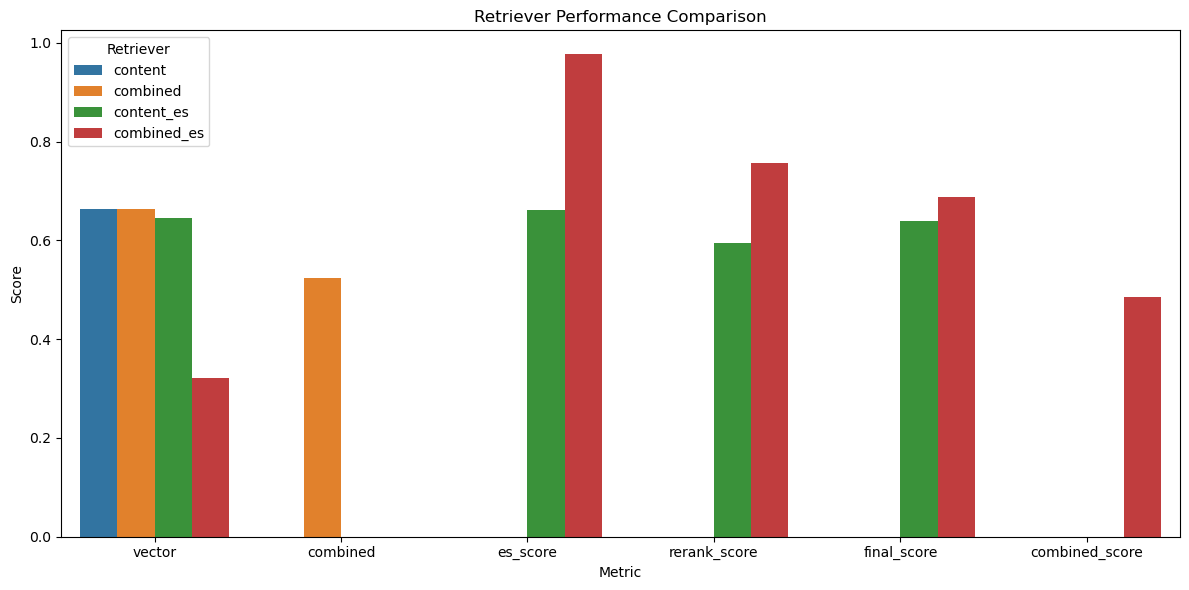

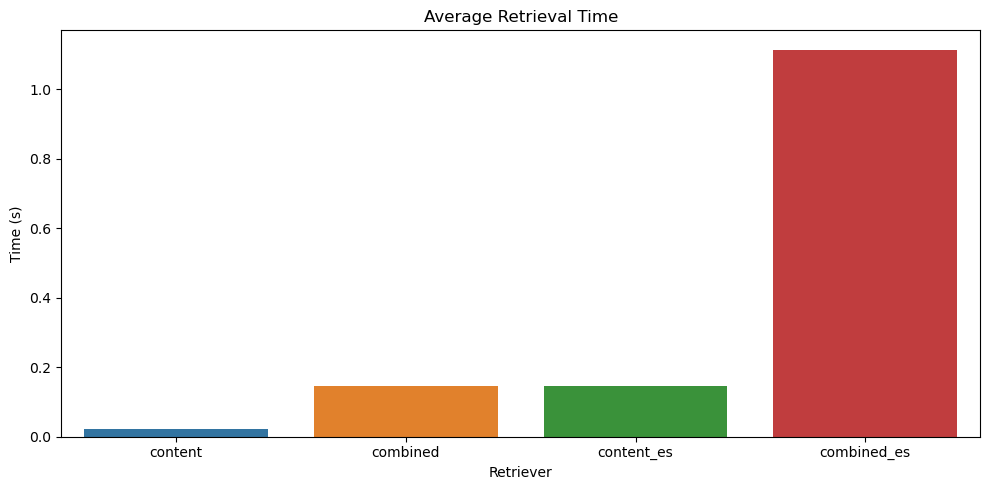


Retrieval comparison complete!


In [15]:
results, stats = run_retriever_comparison()
print("\nRetrieval comparison complete!")

Let me explain how the four retrievers work and how their scores are calculated, all using the same underlying index but with different retrieval strategies.

## Overview of the Four Retrievers

I've implemented four different retrievers that all use the same FAISS index but apply different retrieval strategies:

1. **ContentRetriever**: Pure vector similarity search on document content
2. **CombinedRetriever**: Vector search with added metadata influence 
3. **ContentESRetriever**: Content-based retrieval enhanced with Elasticsearch and reranking
4. **CombinedESRetriever**: Combined retrieval enhanced with Elasticsearch and reranking

## Score Calculation for Each Retriever

### 1. ContentRetriever
- **Score Components**:
  - `vector`: Cosine similarity between query and document embeddings
- **Final Score Calculation**:
  - Uses only vector similarity from FAISS index
  - No weights or combinations - pure semantic search

### 2. CombinedRetriever
- **Score Components**:
  - `vector`: Cosine similarity between query and document embeddings (70%)
  - `metadata`: Score based on topic and entity matches between query and document metadata (30%)
- **Final Score Calculation**:
  - `combined = 0.7 * vector_score + 0.3 * metadata_score`

### 3. ContentESRetriever
- **Score Components**:
  - `content_score`: Vector similarity from FAISS (weight = 0.5)
  - `es_score`: BM25 score from Elasticsearch (weight = 0.3)
  - `rerank_score`: Score from cross-encoder reranking (weight = 0.2)
- **Final Score Calculation**:
  - `final_score = 0.5 * content_score + 0.3 * es_score + 0.2 * rerank_score`

### 4. CombinedESRetriever
- **Score Components**:
  - `combined_score`: Combined vector and metadata score (weight = 0.5)
  - `es_score`: BM25 score from Elasticsearch (weight = 0.3)
  - `rerank_score`: Score from cross-encoder reranking (weight = 0.2)
- **Final Score Calculation**:
  - `final_score = 0.5 * combined_score + 0.3 * es_score + 0.2 * rerank_score`
  - Where `combined_score = 0.7 * vector_score + 0.3 * metadata_score`

## Retrieval Process Summary

Here's a step-by-step breakdown of how each retriever works:

### 1. ContentRetriever
1. Encode query into vector embedding
2. Search FAISS index for nearest neighbors
3. Return top-k chunks with vector similarity scores

### 2. CombinedRetriever
1. Encode query into vector embedding
2. Search FAISS index for nearest neighbors
3. Calculate metadata score for each candidate (topic/entity matching)
4. Calculate combined score by weighting vector and metadata scores
5. Rank results and return top-k chunks

### 3. ContentESRetriever
1. Encode query into vector embedding
2. Search FAISS index for nearest neighbors (content-based)
3. Search Elasticsearch index with the same query
4. Combine unique results from both sources
5. Rerank top candidates using cross-encoder
6. Calculate final weighted score across all three methods
7. Return top-k chunks

### 4. CombinedESRetriever
1. Encode query into vector embedding
2. Search FAISS index for nearest neighbors (combined approach)
3. Calculate metadata score for each candidate
4. Search Elasticsearch index with the same query
5. Combine unique results from both sources
6. Rerank top candidates using cross-encoder
7. Calculate final weighted score across all three methods
8. Return top-k chunks

Each retriever uses the same FAISS index and chunk data but applies different algorithms and weights to calculate relevance scores. This approach allows you to compare different retrieval strategies while maintaining a single source of truth for your document data.